In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import yfinance as yf

C:\Users\krzys\AppData\Local\Temp\ipykernel_152\2623612840.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df = df[['Close']]  

df.reset_index(inplace=True)
df.rename(columns={"Date": "date", "Close": "value"}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype('float32')

df.set_index("date", inplace=True)
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='d')

df = df.reindex(full_index)

df.fillna(method='ffill', inplace=True)

df.head()

C:\Users\krzys\AppData\Local\Temp\ipykernel_152\2354060357.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,value
1993-08-12 00:00:00-04:00,2.754306
1993-08-13 00:00:00-04:00,2.670112
1993-08-14 00:00:00-04:00,2.670112
1993-08-15 00:00:00-04:00,2.670112
1993-08-16 00:00:00-04:00,2.694168


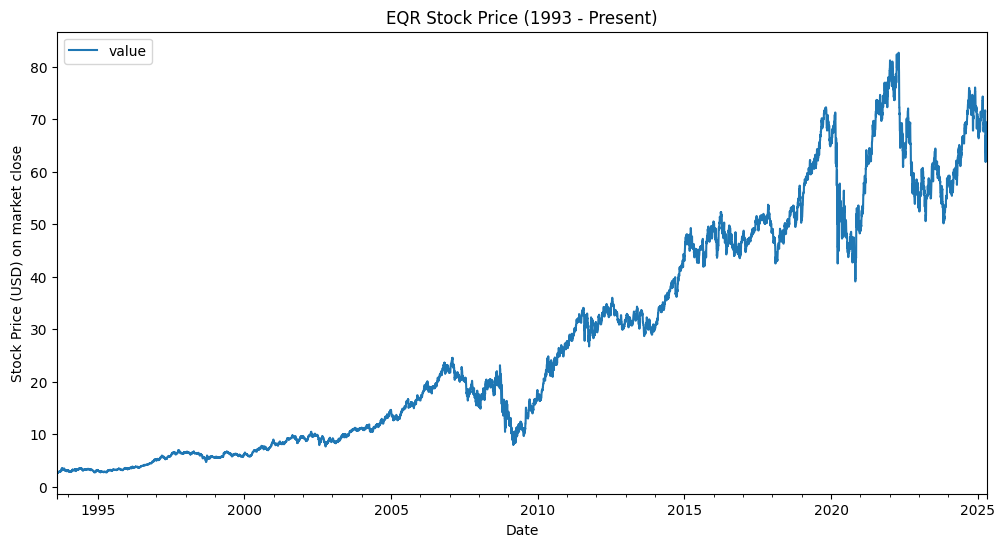

(11579, 1)


In [3]:
df.plot(title='EQR Stock Price (1993 - Present)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Stock Price (USD) on market close')
plt.show()
print(df.shape)

In [4]:
train_end = round(len(df) * 0.7)
valid_end = round(len(df) * 0.9)

train = PandasDataset(df[:train_end], freq="d", target="value")
valid = PandasDataset(df[train_end:valid_end], freq="d", target="value")
test = PandasDataset(df[valid_end:], freq="d", target="value")

In [5]:
#predict next week
prediction_length = 7
context_length = prediction_length * 3
num_samples = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [6]:
import os
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [ ]:
# from pathlib import Path

# best_score = float("inf")
# evaluator = Evaluator()

# def objective(trial):
#     global best_score

#     config = {
#         "input_size": trial.suggest_categorical("input_size", [1, 2, 4]),
#         "n_layer": trial.suggest_int("n_layer", 2, 8),
#         "n_embd_per_head": trial.suggest_categorical("n_embd_per_head", [16, 32, 64]),
#         "n_head": trial.suggest_categorical("n_head", [2, 4, 8]),
#         "scaling": trial.suggest_float("scaling", 0.5, 2.0),
#         "time_feat": trial.suggest_categorical("time_feat", [True, False]),
#         "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
#     }

#     estimator = LagLlamaEstimator(
#         prediction_length=prediction_length,
#         context_length=context_length,
#         device=device,
#         nonnegative_pred_samples=True,

#         rope_scaling={
#             "type": "linear",
#             "factor": max(1.0, (context_length + prediction_length) / context_length),
#         },
#         num_parallel_samples=num_samples,
#         **config
#     )

#     try:
#         predictor = estimator.train(
#             train,
#             valid,
#             cache_data=True,
#             shuffle_buffer_length=1000,
#             max_epochs=20,
#             patience=5,
#             lr_scheduler="cosine_annealing",
#             learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
#             weight_decay=trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True)
#         )

#         forecast_it, ts_it = make_evaluation_predictions(
#             dataset=valid,
#             predictor=predictor,
#             num_samples=num_samples
#         )

#         agg_metrics, _ = evaluator(ts_it, forecast_it)
#         mape = agg_metrics["MAPE"]

#         if mape < best_score:
#             best_score = mape
#             print(f"New best MAPE: {mape:.4f}, saving model...")
            
#             Path("best_model").mkdir(parents=True, exist_ok=True)
#             predictor.serialize(Path("best_model"))

#         return mape
    
#     except Exception as e:
#         print(f"Trial failed: {e}")
#         return float("inf")

In [ ]:
# import optuna

# study = optuna.create_study(study_name="lag_llama_tune", storage="sqlite:///optuna.db", direction="minimize", load_if_exists=True)
# study.optimize(objective, n_trials=30, timeout=3600)

[I 2025-04-24 23:47:42,637] Using an existing study with name 'lag_llama_tune' instead of creating a new one.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 3.4 M 


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:02<00:00, 19.78it/s, v_num=16]

Epoch 0, global step 50: 'val_loss' reached 8.33621 (best 8.33621), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_16\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 26.88it/s, v_num=16]

Epoch 1, global step 100: 'val_loss' reached 7.95009 (best 7.95009), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_16\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 26.40it/s, v_num=16]

Epoch 2, global step 150: 'val_loss' reached 7.72875 (best 7.72875), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_16\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 26.21it/s, v_num=16]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 28.33it/s, v_num=16]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 27.77it/s, v_num=16]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 27.44it/s, v_num=16]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 27.03it/s, v_num=16]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 27.61it/s, v_num=16]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 29.04it/s, v_num=16]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 28.59it/s, v_num=16]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 28.09it/s, v_num=16]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 29.62it/s, v_num=16]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 28.94it/s, v_num=16]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 28.84it/s, v_num=16]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 25.18it/s, v_num=16]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 26.07it/s, v_num=16]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 27.65it/s, v_num=16]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 27.75it/s, v_num=16]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 27.32it/s, v_num=16]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 28.43it/s, v_num=16]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 28.07it/s, v_num=16]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 29.94it/s, v_num=16]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 27.34it/s, v_num=16]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 26.25it/s, v_num=16]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 25.50it/s, v_num=16]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 26.61it/s, v_num=16]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 27.22it/s, v_num=16]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:02<00:00, 24.72it/s, v_num=16]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 26.34it/s, v_num=16]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:02<00:00, 23.55it/s, v_num=16]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 25.35it/s, v_num=16]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 27.55it/s, v_num=16]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 25.51it/s, v_num=16]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 25.28it/s, v_num=16]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 25.92it/s, v_num=16]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 27.44it/s, v_num=16]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 27.17it/s, v_num=16]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 28.54it/s, v_num=16]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 27.78it/s, v_num=16]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 28.10it/s, v_num=16]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 26.16it/s, v_num=16]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 26.94it/s, v_num=16]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 27.10it/s, v_num=16]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 25.96it/s, v_num=16]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:02<00:00, 22.67it/s, v_num=16]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:02<00:00, 23.26it/s, v_num=16]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 26.85it/s, v_num=16]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:02<00:00, 22.38it/s, v_num=16]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 27.84it/s, v_num=16]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:02<00:00, 23.12it/s, v_num=16]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:02<00:00, 24.55it/s, v_num=16]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 25.53it/s, v_num=16]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 25.71it/s, v_num=16]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 26.27it/s, v_num=16]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 27.24it/s, v_num=16]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 26.97it/s, v_num=16]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 27.67it/s, v_num=16]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 27.96it/s, v_num=16]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 27.25it/s, v_num=16]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 26.93it/s, v_num=16]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 28.10it/s, v_num=16]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 27.33it/s, v_num=16]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 28.03it/s, v_num=16]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 27.45it/s, v_num=16]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 28.01it/s, v_num=16]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 27.54it/s, v_num=16]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 25.33it/s, v_num=16]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 25.71it/s, v_num=16]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 25.88it/s, v_num=16]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 26.66it/s, v_num=16]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 26.53it/s, v_num=16]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 26.48it/s, v_num=16]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 26.91it/s, v_num=16]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 27.19it/s, v_num=16]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 26.80it/s, v_num=16]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:02<00:00, 21.68it/s, v_num=16]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:02<00:00, 18.35it/s, v_num=16]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:02<00:00, 20.50it/s, v_num=16]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:02<00:00, 22.99it/s, v_num=16]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 26.03it/s, v_num=16]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 27.92it/s, v_num=16]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 25.76it/s, v_num=16]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:02<00:00, 20.75it/s, v_num=16]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 28.14it/s, v_num=16]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:02<00:00, 24.63it/s, v_num=16]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 27.23it/s, v_num=16]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 25.81it/s, v_num=16]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 27.58it/s, v_num=16]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:02<00:00, 24.59it/s, v_num=16]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 28.62it/s, v_num=16]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 27.00it/s, v_num=16]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 28.11it/s, v_num=16]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 27.34it/s, v_num=16]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 27.84it/s, v_num=16]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 27.86it/s, v_num=16]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 26.17it/s, v_num=16]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 28.47it/s, v_num=16]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 28.60it/s, v_num=16]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 28.23it/s, v_num=16]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 27.61it/s, v_num=16]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 10.75it/s]
[I 2025-04-24 23:50:58,197] Trial 14 finished with value: 0.7716043336050851 and parameters: {'input_size': 1, 'n_layer': 4, 'n_embd_per_head': 32, 'n_head': 8, 'scaling': 1.275067716151516, 'time_feat': True, 'batch_size': 16, 'learning_rate': 8.912594133456252e-05, 'weight_decay': 0.0017784336403503804}. Best is trial 14 with value: 0.7716043336050851.


New best MAPE: 0.7716, saving model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 3.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.739    Total estimated model params size (MB)


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 27.92it/s, v_num=17]

Epoch 0, global step 50: 'val_loss' reached 8.33665 (best 8.33665), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_17\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 26.26it/s, v_num=17]

Epoch 1, global step 100: 'val_loss' reached 7.97090 (best 7.97090), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_17\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 27.81it/s, v_num=17]

Epoch 2, global step 150: 'val_loss' reached 7.89268 (best 7.89268), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_17\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 28.31it/s, v_num=17]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 25.28it/s, v_num=17]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 25.32it/s, v_num=17]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 28.39it/s, v_num=17]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 28.51it/s, v_num=17]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 28.11it/s, v_num=17]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 28.57it/s, v_num=17]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 26.34it/s, v_num=17]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 27.29it/s, v_num=17]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:02<00:00, 23.58it/s, v_num=17]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:02<00:00, 21.88it/s, v_num=17]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:02<00:00, 24.59it/s, v_num=17]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 28.67it/s, v_num=17]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 27.87it/s, v_num=17]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:02<00:00, 24.94it/s, v_num=17]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 25.96it/s, v_num=17]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:02<00:00, 21.44it/s, v_num=17]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 26.82it/s, v_num=17]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:02<00:00, 24.70it/s, v_num=17]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 26.64it/s, v_num=17]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 26.19it/s, v_num=17]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 25.58it/s, v_num=17]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:02<00:00, 23.02it/s, v_num=17]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 27.35it/s, v_num=17]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:02<00:00, 23.33it/s, v_num=17]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 26.78it/s, v_num=17]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 25.79it/s, v_num=17]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 26.82it/s, v_num=17]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 25.15it/s, v_num=17]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:02<00:00, 23.38it/s, v_num=17]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 25.54it/s, v_num=17]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 27.35it/s, v_num=17]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 27.28it/s, v_num=17]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 28.52it/s, v_num=17]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 28.03it/s, v_num=17]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 28.06it/s, v_num=17]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:02<00:00, 23.55it/s, v_num=17]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 25.87it/s, v_num=17]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:02<00:00, 23.52it/s, v_num=17]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:02<00:00, 23.32it/s, v_num=17]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 26.70it/s, v_num=17]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:02<00:00, 22.12it/s, v_num=17]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 25.76it/s, v_num=17]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 25.20it/s, v_num=17]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:02<00:00, 24.13it/s, v_num=17]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 26.45it/s, v_num=17]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:02<00:00, 24.61it/s, v_num=17]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 27.93it/s, v_num=17]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 26.93it/s, v_num=17]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 28.41it/s, v_num=17]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 28.36it/s, v_num=17]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 26.40it/s, v_num=17]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:02<00:00, 20.58it/s, v_num=17]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:02<00:00, 22.59it/s, v_num=17]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 25.25it/s, v_num=17]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 25.34it/s, v_num=17]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 26.14it/s, v_num=17]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 27.09it/s, v_num=17]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 26.00it/s, v_num=17]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 26.50it/s, v_num=17]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 28.14it/s, v_num=17]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 28.18it/s, v_num=17]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 26.19it/s, v_num=17]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:02<00:00, 23.81it/s, v_num=17]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 27.58it/s, v_num=17]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 25.38it/s, v_num=17]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 27.47it/s, v_num=17]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 25.49it/s, v_num=17]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:02<00:00, 23.98it/s, v_num=17]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 27.36it/s, v_num=17]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 27.47it/s, v_num=17]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 27.72it/s, v_num=17]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 25.81it/s, v_num=17]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 27.93it/s, v_num=17]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 27.75it/s, v_num=17]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 28.69it/s, v_num=17]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 26.21it/s, v_num=17]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 25.28it/s, v_num=17]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 27.41it/s, v_num=17]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 26.01it/s, v_num=17]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 25.81it/s, v_num=17]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:02<00:00, 24.51it/s, v_num=17]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:02<00:00, 22.60it/s, v_num=17]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:02<00:00, 23.08it/s, v_num=17]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:02<00:00, 24.17it/s, v_num=17]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 26.97it/s, v_num=17]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 27.04it/s, v_num=17]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 26.51it/s, v_num=17]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:02<00:00, 24.94it/s, v_num=17]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 26.00it/s, v_num=17]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 26.07it/s, v_num=17]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 25.55it/s, v_num=17]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 27.06it/s, v_num=17]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 26.61it/s, v_num=17]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:02<00:00, 24.99it/s, v_num=17]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 27.65it/s, v_num=17]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 27.11it/s, v_num=17]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 26.64it/s, v_num=17]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 12.66it/s]
[I 2025-04-24 23:54:16,312] Trial 15 finished with value: 0.7308285576956612 and parameters: {'input_size': 1, 'n_layer': 4, 'n_embd_per_head': 32, 'n_head': 8, 'scaling': 1.2493595368647235, 'time_feat': True, 'batch_size': 16, 'learning_rate': 7.18063340296473e-05, 'weight_decay': 0.0021989261207515745}. Best is trial 15 with value: 0.7308285576956612.


New best MAPE: 0.7308, saving model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 3.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.739    Total estimated model params size (MB)


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 26.34it/s, v_num=18]

Epoch 0, global step 50: 'val_loss' reached 8.16788 (best 8.16788), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_18\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 23.56it/s, v_num=18]

Epoch 1, global step 100: 'val_loss' reached 7.84155 (best 7.84155), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_18\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 27.62it/s, v_num=18]

Epoch 2, global step 150: 'val_loss' was not in top 1


Epoch 3: |          | 50/? [00:01<00:00, 26.00it/s, v_num=18]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 27.10it/s, v_num=18]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 25.69it/s, v_num=18]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 25.33it/s, v_num=18]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 25.87it/s, v_num=18]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 27.72it/s, v_num=18]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 27.08it/s, v_num=18]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 27.81it/s, v_num=18]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 26.30it/s, v_num=18]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 26.18it/s, v_num=18]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 27.68it/s, v_num=18]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 27.78it/s, v_num=18]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 26.25it/s, v_num=18]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 27.85it/s, v_num=18]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 27.25it/s, v_num=18]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 25.79it/s, v_num=18]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 28.14it/s, v_num=18]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 27.11it/s, v_num=18]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 27.23it/s, v_num=18]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 27.24it/s, v_num=18]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 25.14it/s, v_num=18]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 25.35it/s, v_num=18]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:02<00:00, 18.56it/s, v_num=18]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:02<00:00, 22.49it/s, v_num=18]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:02<00:00, 23.37it/s, v_num=18]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 26.34it/s, v_num=18]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 26.43it/s, v_num=18]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 27.31it/s, v_num=18]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 25.88it/s, v_num=18]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 26.19it/s, v_num=18]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:02<00:00, 24.59it/s, v_num=18]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:02<00:00, 23.23it/s, v_num=18]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:02<00:00, 23.52it/s, v_num=18]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 25.23it/s, v_num=18]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 26.53it/s, v_num=18]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 27.70it/s, v_num=18]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 27.93it/s, v_num=18]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 27.75it/s, v_num=18]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 27.03it/s, v_num=18]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 25.32it/s, v_num=18]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 29.22it/s, v_num=18]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 28.41it/s, v_num=18]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 27.00it/s, v_num=18]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 26.53it/s, v_num=18]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 27.90it/s, v_num=18]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:02<00:00, 24.16it/s, v_num=18]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 28.74it/s, v_num=18]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 28.53it/s, v_num=18]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 28.04it/s, v_num=18]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 28.66it/s, v_num=18]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 28.07it/s, v_num=18]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 29.64it/s, v_num=18]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 27.07it/s, v_num=18]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 27.39it/s, v_num=18]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 29.00it/s, v_num=18]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 28.59it/s, v_num=18]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 28.72it/s, v_num=18]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 25.28it/s, v_num=18]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 27.06it/s, v_num=18]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 27.40it/s, v_num=18]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 28.07it/s, v_num=18]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 29.38it/s, v_num=18]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 29.62it/s, v_num=18]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 27.95it/s, v_num=18]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 28.52it/s, v_num=18]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 28.44it/s, v_num=18]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 27.05it/s, v_num=18]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 26.54it/s, v_num=18]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 28.99it/s, v_num=18]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 29.19it/s, v_num=18]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 27.52it/s, v_num=18]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 29.20it/s, v_num=18]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 28.64it/s, v_num=18]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 27.86it/s, v_num=18]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 25.41it/s, v_num=18]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 28.81it/s, v_num=18]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 26.52it/s, v_num=18]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:02<00:00, 24.30it/s, v_num=18]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 27.65it/s, v_num=18]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 28.75it/s, v_num=18]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 26.62it/s, v_num=18]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 26.74it/s, v_num=18]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:02<00:00, 23.16it/s, v_num=18]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 27.32it/s, v_num=18]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:02<00:00, 24.73it/s, v_num=18]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 26.59it/s, v_num=18]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 27.55it/s, v_num=18]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 25.97it/s, v_num=18]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 27.48it/s, v_num=18]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 29.18it/s, v_num=18]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 27.79it/s, v_num=18]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 29.27it/s, v_num=18]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 28.92it/s, v_num=18]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 28.92it/s, v_num=18]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 28.04it/s, v_num=18]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 25.52it/s, v_num=18]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 26.60it/s, v_num=18]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 26.12it/s, v_num=18]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 12.20it/s]
[I 2025-04-24 23:57:27,275] Trial 16 finished with value: 0.8359168597630092 and parameters: {'input_size': 1, 'n_layer': 4, 'n_embd_per_head': 32, 'n_head': 8, 'scaling': 1.2191828546660972, 'time_feat': True, 'batch_size': 16, 'learning_rate': 0.00010159777700712269, 'weight_decay': 0.003369054443555994}. Best is trial 15 with value: 0.7308285576956612.
GPU available: True (cuda), used: True
TPU available: False, using: 0

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 25.87it/s, v_num=19]

Epoch 0, global step 50: 'val_loss' reached 8.30471 (best 8.30471), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_19\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 25.84it/s, v_num=19]

Epoch 1, global step 100: 'val_loss' reached 8.06299 (best 8.06299), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_19\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 26.97it/s, v_num=19]

Epoch 2, global step 150: 'val_loss' was not in top 1


Epoch 3: |          | 50/? [00:01<00:00, 27.79it/s, v_num=19]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 26.01it/s, v_num=19]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 28.26it/s, v_num=19]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 27.76it/s, v_num=19]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 25.48it/s, v_num=19]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 25.92it/s, v_num=19]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 28.69it/s, v_num=19]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 28.85it/s, v_num=19]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 29.10it/s, v_num=19]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 28.36it/s, v_num=19]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 28.85it/s, v_num=19]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 29.38it/s, v_num=19]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:02<00:00, 24.15it/s, v_num=19]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 26.15it/s, v_num=19]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 26.64it/s, v_num=19]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 28.47it/s, v_num=19]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 29.55it/s, v_num=19]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 30.28it/s, v_num=19]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 29.67it/s, v_num=19]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 30.30it/s, v_num=19]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 30.18it/s, v_num=19]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 30.75it/s, v_num=19]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 30.07it/s, v_num=19]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 30.16it/s, v_num=19]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 29.69it/s, v_num=19]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 30.58it/s, v_num=19]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 30.21it/s, v_num=19]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 29.89it/s, v_num=19]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 30.35it/s, v_num=19]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 29.87it/s, v_num=19]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 29.85it/s, v_num=19]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 31.17it/s, v_num=19]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 29.62it/s, v_num=19]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 30.49it/s, v_num=19]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 29.39it/s, v_num=19]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 31.47it/s, v_num=19]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 30.54it/s, v_num=19]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 31.37it/s, v_num=19]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 30.98it/s, v_num=19]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 31.41it/s, v_num=19]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 30.75it/s, v_num=19]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 30.75it/s, v_num=19]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 29.96it/s, v_num=19]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 30.67it/s, v_num=19]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 27.29it/s, v_num=19]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 29.02it/s, v_num=19]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 29.87it/s, v_num=19]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 30.05it/s, v_num=19]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 32.02it/s, v_num=19]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 31.02it/s, v_num=19]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 30.79it/s, v_num=19]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 30.64it/s, v_num=19]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 30.03it/s, v_num=19]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 30.30it/s, v_num=19]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 30.04it/s, v_num=19]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 29.96it/s, v_num=19]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 30.86it/s, v_num=19]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 30.88it/s, v_num=19]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 30.96it/s, v_num=19]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 30.36it/s, v_num=19]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 30.90it/s, v_num=19]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 30.92it/s, v_num=19]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 30.01it/s, v_num=19]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 31.53it/s, v_num=19]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 29.76it/s, v_num=19]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 30.56it/s, v_num=19]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 30.34it/s, v_num=19]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 30.45it/s, v_num=19]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 30.41it/s, v_num=19]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 30.23it/s, v_num=19]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 30.67it/s, v_num=19]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 31.04it/s, v_num=19]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 29.93it/s, v_num=19]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 30.63it/s, v_num=19]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 30.45it/s, v_num=19]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 31.15it/s, v_num=19]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 29.41it/s, v_num=19]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 27.95it/s, v_num=19]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 28.52it/s, v_num=19]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 29.74it/s, v_num=19]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 30.77it/s, v_num=19]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 30.94it/s, v_num=19]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 30.88it/s, v_num=19]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 30.25it/s, v_num=19]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 30.16it/s, v_num=19]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 29.89it/s, v_num=19]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 30.01it/s, v_num=19]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 30.19it/s, v_num=19]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 30.10it/s, v_num=19]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 30.36it/s, v_num=19]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 31.23it/s, v_num=19]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 29.96it/s, v_num=19]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 29.78it/s, v_num=19]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 30.62it/s, v_num=19]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 29.52it/s, v_num=19]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 31.29it/s, v_num=19]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 29.98it/s, v_num=19]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 29.38it/s, v_num=19]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 13.89it/s]
[I 2025-04-25 00:00:19,994] Trial 17 finished with value: 0.8066560200282505 and parameters: {'input_size': 1, 'n_layer': 4, 'n_embd_per_head': 32, 'n_head': 8, 'scaling': 1.2080111505979076, 'time_feat': True, 'batch_size': 16, 'learning_rate': 9.787145718213609e-05, 'weight_decay': 0.0019251964521661944}. Best is trial 15 with value: 0.7308285576956612.
GPU available: True (cuda), used: True
TPU available: False, using: 0

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 26.18it/s, v_num=20]

Epoch 0, global step 50: 'val_loss' reached 8.89378 (best 8.89378), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_20\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 24.67it/s, v_num=20]

Epoch 1, global step 100: 'val_loss' reached 8.46548 (best 8.46548), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_20\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 25.48it/s, v_num=20]

Epoch 2, global step 150: 'val_loss' reached 8.14397 (best 8.14397), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_20\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 25.80it/s, v_num=20]

Epoch 3, global step 200: 'val_loss' reached 7.97666 (best 7.97666), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_20\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 25.83it/s, v_num=20]

Epoch 4, global step 250: 'val_loss' reached 7.84736 (best 7.84736), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_20\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 25.89it/s, v_num=20]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 25.71it/s, v_num=20]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 25.52it/s, v_num=20]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 25.76it/s, v_num=20]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:02<00:00, 24.74it/s, v_num=20]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 25.09it/s, v_num=20]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 25.05it/s, v_num=20]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 25.34it/s, v_num=20]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 26.03it/s, v_num=20]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 25.72it/s, v_num=20]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 25.85it/s, v_num=20]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 25.08it/s, v_num=20]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 25.67it/s, v_num=20]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 26.00it/s, v_num=20]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:02<00:00, 24.98it/s, v_num=20]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 25.14it/s, v_num=20]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 25.01it/s, v_num=20]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 25.37it/s, v_num=20]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 25.43it/s, v_num=20]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 25.38it/s, v_num=20]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:02<00:00, 24.10it/s, v_num=20]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 25.54it/s, v_num=20]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:02<00:00, 24.27it/s, v_num=20]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 25.20it/s, v_num=20]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:02<00:00, 24.52it/s, v_num=20]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 25.71it/s, v_num=20]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:02<00:00, 22.25it/s, v_num=20]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:02<00:00, 21.63it/s, v_num=20]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:02<00:00, 23.20it/s, v_num=20]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:02<00:00, 24.12it/s, v_num=20]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:02<00:00, 24.68it/s, v_num=20]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:02<00:00, 24.27it/s, v_num=20]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:02<00:00, 24.65it/s, v_num=20]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:02<00:00, 24.47it/s, v_num=20]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:02<00:00, 23.74it/s, v_num=20]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 25.87it/s, v_num=20]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:02<00:00, 24.52it/s, v_num=20]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:02<00:00, 24.73it/s, v_num=20]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:02<00:00, 24.11it/s, v_num=20]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 25.14it/s, v_num=20]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:02<00:00, 24.28it/s, v_num=20]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 25.84it/s, v_num=20]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:02<00:00, 24.69it/s, v_num=20]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:02<00:00, 24.68it/s, v_num=20]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:02<00:00, 24.94it/s, v_num=20]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:02<00:00, 24.80it/s, v_num=20]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:02<00:00, 23.52it/s, v_num=20]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:02<00:00, 23.80it/s, v_num=20]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 25.38it/s, v_num=20]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 25.59it/s, v_num=20]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:02<00:00, 23.54it/s, v_num=20]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 25.99it/s, v_num=20]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 25.34it/s, v_num=20]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 25.77it/s, v_num=20]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 25.03it/s, v_num=20]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:02<00:00, 24.24it/s, v_num=20]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 26.30it/s, v_num=20]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 25.46it/s, v_num=20]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:02<00:00, 24.49it/s, v_num=20]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 25.35it/s, v_num=20]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:02<00:00, 24.74it/s, v_num=20]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 25.58it/s, v_num=20]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 25.43it/s, v_num=20]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:02<00:00, 24.51it/s, v_num=20]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 25.20it/s, v_num=20]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:02<00:00, 24.95it/s, v_num=20]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 25.38it/s, v_num=20]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 25.27it/s, v_num=20]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:02<00:00, 24.34it/s, v_num=20]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 25.37it/s, v_num=20]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:02<00:00, 23.76it/s, v_num=20]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 25.72it/s, v_num=20]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 25.23it/s, v_num=20]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:02<00:00, 24.51it/s, v_num=20]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 25.20it/s, v_num=20]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 25.47it/s, v_num=20]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:02<00:00, 24.53it/s, v_num=20]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 25.60it/s, v_num=20]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:02<00:00, 24.87it/s, v_num=20]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:02<00:00, 24.63it/s, v_num=20]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 25.59it/s, v_num=20]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 25.09it/s, v_num=20]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:02<00:00, 24.99it/s, v_num=20]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:02<00:00, 24.24it/s, v_num=20]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:02<00:00, 24.73it/s, v_num=20]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 25.13it/s, v_num=20]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:02<00:00, 24.30it/s, v_num=20]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:02<00:00, 24.07it/s, v_num=20]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:02<00:00, 23.78it/s, v_num=20]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 25.75it/s, v_num=20]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 25.00it/s, v_num=20]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:02<00:00, 24.50it/s, v_num=20]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:02<00:00, 24.81it/s, v_num=20]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 25.16it/s, v_num=20]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 25.16it/s, v_num=20]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:02<00:00, 24.75it/s, v_num=20]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00,  7.63it/s]
[I 2025-04-25 00:03:44,617] Trial 18 finished with value: 0.768024376460484 and parameters: {'input_size': 1, 'n_layer': 6, 'n_embd_per_head': 16, 'n_head': 8, 'scaling': 1.4512484121367208, 'time_feat': True, 'batch_size': 16, 'learning_rate': 9.013152284153518e-05, 'weight_decay': 0.0041627484189846915}. Best is trial 15 with value: 0.7308285576956612.
GPU available: True (cuda), used: True
TPU available: False, using: 0 

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 25.36it/s, v_num=21]

Epoch 0, global step 50: 'val_loss' reached 8.84673 (best 8.84673), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_21\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 24.07it/s, v_num=21]

Epoch 1, global step 100: 'val_loss' reached 8.40241 (best 8.40241), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_21\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 23.76it/s, v_num=21]

Epoch 2, global step 150: 'val_loss' reached 8.09811 (best 8.09811), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_21\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 23.07it/s, v_num=21]

Epoch 3, global step 200: 'val_loss' reached 7.91232 (best 7.91232), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_21\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:02<00:00, 24.14it/s, v_num=21]

Epoch 4, global step 250: 'val_loss' reached 7.80046 (best 7.80046), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_21\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:02<00:00, 24.64it/s, v_num=21]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:02<00:00, 24.67it/s, v_num=21]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:02<00:00, 24.99it/s, v_num=21]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:02<00:00, 24.14it/s, v_num=21]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 25.03it/s, v_num=21]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 25.21it/s, v_num=21]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:02<00:00, 24.88it/s, v_num=21]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 25.84it/s, v_num=21]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 25.05it/s, v_num=21]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 25.14it/s, v_num=21]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 25.03it/s, v_num=21]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:02<00:00, 24.11it/s, v_num=21]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 25.34it/s, v_num=21]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:02<00:00, 25.00it/s, v_num=21]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 25.01it/s, v_num=21]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 25.84it/s, v_num=21]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:02<00:00, 23.53it/s, v_num=21]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:02<00:00, 24.73it/s, v_num=21]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 25.45it/s, v_num=21]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 25.14it/s, v_num=21]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 25.35it/s, v_num=21]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 25.21it/s, v_num=21]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:02<00:00, 23.21it/s, v_num=21]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:02<00:00, 21.42it/s, v_num=21]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:02<00:00, 17.55it/s, v_num=21]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:03<00:00, 16.64it/s, v_num=21]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:02<00:00, 19.85it/s, v_num=21]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:02<00:00, 20.57it/s, v_num=21]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:02<00:00, 19.31it/s, v_num=21]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:02<00:00, 21.11it/s, v_num=21]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:02<00:00, 20.32it/s, v_num=21]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:02<00:00, 21.86it/s, v_num=21]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:02<00:00, 18.90it/s, v_num=21]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:02<00:00, 20.52it/s, v_num=21]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:02<00:00, 22.33it/s, v_num=21]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:02<00:00, 21.58it/s, v_num=21]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:02<00:00, 21.63it/s, v_num=21]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:02<00:00, 22.08it/s, v_num=21]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:02<00:00, 21.45it/s, v_num=21]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:02<00:00, 24.33it/s, v_num=21]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:02<00:00, 21.94it/s, v_num=21]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:02<00:00, 19.75it/s, v_num=21]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:02<00:00, 24.40it/s, v_num=21]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:02<00:00, 24.50it/s, v_num=21]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 25.47it/s, v_num=21]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 25.43it/s, v_num=21]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 25.16it/s, v_num=21]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:02<00:00, 24.62it/s, v_num=21]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:02<00:00, 24.85it/s, v_num=21]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 25.08it/s, v_num=21]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:02<00:00, 21.42it/s, v_num=21]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:03<00:00, 13.05it/s, v_num=21]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:03<00:00, 14.67it/s, v_num=21]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:02<00:00, 17.26it/s, v_num=21]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:02<00:00, 18.67it/s, v_num=21]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:02<00:00, 21.35it/s, v_num=21]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:02<00:00, 20.19it/s, v_num=21]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:02<00:00, 21.29it/s, v_num=21]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:02<00:00, 21.55it/s, v_num=21]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:02<00:00, 22.94it/s, v_num=21]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:02<00:00, 22.87it/s, v_num=21]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:02<00:00, 20.03it/s, v_num=21]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:02<00:00, 21.28it/s, v_num=21]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:02<00:00, 20.92it/s, v_num=21]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:02<00:00, 23.23it/s, v_num=21]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:02<00:00, 21.32it/s, v_num=21]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:02<00:00, 21.87it/s, v_num=21]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 13/? [00:00<00:00, 19.76it/s, v_num=21]

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00,  9.62it/s]
[I 2025-04-25 00:06:30,663] Trial 19 finished with value: 0.7946948323931012 and parameters: {'input_size': 1, 'n_layer': 6, 'n_embd_per_head': 16, 'n_head': 8, 'scaling': 1.5333277582090017, 'time_feat': True, 'batch_size': 16, 'learning_rate': 0.00021176705071718584, 'weight_decay': 0.004725751744899973

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:02<00:00, 23.25it/s, v_num=22]

Epoch 0, global step 50: 'val_loss' reached 8.80089 (best 8.80089), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_22\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 23.29it/s, v_num=22]

Epoch 1, global step 100: 'val_loss' reached 8.32302 (best 8.32302), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_22\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 22.39it/s, v_num=22]

Epoch 2, global step 150: 'val_loss' reached 8.06081 (best 8.06081), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_22\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 23.89it/s, v_num=22]

Epoch 3, global step 200: 'val_loss' reached 7.90117 (best 7.90117), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_22\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 35/? [00:01<00:00, 23.32it/s, v_num=22]

In [ ]:
# from gluonts.model.predictor import Predictor
# best_predictor = Predictor.deserialize(Path("best_model"))

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\torch\model\predictor.py:117: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  state_dict = torch.load(


#### Results were very bad...

In [9]:
from pathlib import Path

best_score = float("inf")
evaluator = Evaluator()

def objective(trial):
    global best_score

    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    base_args = ckpt["hyper_parameters"]["model_kwargs"]

    trial_args = {
        "input_size": base_args["input_size"],  # or tune if you want
        "n_layer": trial.suggest_int("n_layer", 2, 6),
        "n_embd_per_head": base_args["n_embd_per_head"],  # or make tunable
        "n_head": base_args["n_head"],  # usually fixed
        "scaling": trial.suggest_float("scaling", 0.5, 2.0),
        "time_feat": trial.suggest_categorical("time_feat", [True, False]),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",  
        prediction_length=prediction_length,
        context_length=context_length,
        device=device,
        nonnegative_pred_samples=True,
        num_parallel_samples=num_samples,
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / context_length),
        },
        **trial_args
    )

    try:
        predictor = estimator.train(
            train,
            valid,
            cache_data=True,
            shuffle_buffer_length=1000,
            max_epochs=100,  # maybe increase this
            patience=5,
            lr_scheduler="cosine_annealing",
            learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True),
            weight_decay=trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True),
        )

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=valid,
            predictor=predictor,
            num_samples=num_samples
        )

        agg_metrics, _ = evaluator(ts_it, forecast_it)
        mape = agg_metrics["MAPE"]

        if mape < best_score:
            best_score = mape
            print(f"New best MAPE: {mape:.4f}, saving model...")
            
            Path("best_model").mkdir(parents=True, exist_ok=True)
            predictor.serialize(Path("best_model"))

        return mape
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return float("inf")

In [ ]:
import optuna

study = optuna.create_study(study_name="lag_llama3", storage="sqlite:///optuna_part3.db", direction="minimize", load_if_exists=True)
study.optimize(objective, n_trials=30, timeout=3600)

[I 2025-04-25 10:51:45,538] A new study created in RDB with name: lag_llama3
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
[I 2025-04-25 10:51:46,471] Trial 0 finished with value: inf and parameters: {'n_layer': 6, 'scaling': 0.877396072655626, 'time_feat': False, 'batch_size': 16, 'learning_rate': 9.77317421574804e-05, 'weight_decay': 0.00520285173375596}. Best is trial 0 with value: inf.


Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


[I 2025-04-25 10:51:47,002] Trial 1 finished with value: inf and parameters: {'n_layer': 6, 'scaling': 1.154031526642917, 'time_feat': False, 'batch_size': 32, 'learning_rate': 7.273377050990582e-05, 'weight_decay': 0.007117558358270593}. Best is trial 0 with value: inf.


Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


[I 2025-04-25 10:51:47,453] Trial 2 finished with value: inf and parameters: {'n_layer': 3, 'scaling': 0.6153557034624928, 'time_feat': False, 'batch_size': 16, 'learning_rate': 0.0006294423407789437, 'weight_decay': 0.0002527322169942699}. Best is trial 0 with value: inf.


Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


[I 2025-04-25 10:51:47,902] Trial 3 finished with value: inf and parameters: {'n_layer': 5, 'scaling': 1.0656794329962958, 'time_feat': False, 'batch_size': 64, 'learning_rate': 0.00026022857006062565, 'weight_decay': 0.000628359351650464}. Best is trial 0 with value: inf.


Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


[I 2025-04-25 10:51:48,351] Trial 4 finished with value: inf and parameters: {'n_layer': 3, 'scaling': 0.5206098437602089, 'time_feat': False, 'batch_size': 16, 'learning_rate': 6.36307161951493e-05, 'weight_decay': 0.006079738798274151}. Best is trial 0 with value: inf.


Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\core\saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.transformer.h.3.rms_1.scale', 'model.transformer.h.3.attn.q_proj.weight', 'model.transformer.h.3.attn.kv_proj.weight', 'model.transformer.h.3.attn.c_proj.weight', 'model.transformer.h.3.rms_2.scale', 'model.transformer.h.3.mlp.c_fc1.weight', 'model.transformer.h.3.mlp.c_fc2.weight', 'model.transformer.h.3.mlp.c_proj.weight', 'model.transformer.h.4.rms_1.scale', 'model.transformer.h.4.attn.q_proj.weight', 'model.transformer.h.4.attn.kv_proj.weight', 'model.transformer.h.4.attn.c_proj.weight', 'model.transformer.h.4.rms_2.scale', 'model.transformer.h.4.mlp.c_fc1.weight', 'model.transformer.h.4.mlp.c_fc2.weight', 'model.transformer.h.4.mlp.c_proj.weight', 'model.transformer.h.5.rms_1.scale', 'model.transformer.h.5.attn.q_proj.weight', 'model.transformer.h.5.attn.kv_proj.weight', 'model.transformer.h.5.attn.c_proj.

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:02<00:00, 17.96it/s, v_num=41]

Epoch 0, global step 50: 'val_loss' reached 7.98253 (best 7.98253), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_41\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 26.12it/s, v_num=41]

Epoch 1, global step 100: 'val_loss' reached 7.63500 (best 7.63500), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_41\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 27.81it/s, v_num=41]

Epoch 2, global step 150: 'val_loss' reached 7.47477 (best 7.47477), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_41\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 26.04it/s, v_num=41]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 25.55it/s, v_num=41]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:02<00:00, 23.69it/s, v_num=41]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 26.33it/s, v_num=41]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 25.92it/s, v_num=41]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 25.92it/s, v_num=41]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 26.57it/s, v_num=41]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:02<00:00, 22.61it/s, v_num=41]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:02<00:00, 24.63it/s, v_num=41]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:02<00:00, 24.94it/s, v_num=41]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:02<00:00, 23.13it/s, v_num=41]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 25.03it/s, v_num=41]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 25.46it/s, v_num=41]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 25.19it/s, v_num=41]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 26.32it/s, v_num=41]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 26.84it/s, v_num=41]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 26.10it/s, v_num=41]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 26.16it/s, v_num=41]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:02<00:00, 24.94it/s, v_num=41]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 25.66it/s, v_num=41]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:02<00:00, 20.33it/s, v_num=41]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:02<00:00, 24.58it/s, v_num=41]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 26.95it/s, v_num=41]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 26.27it/s, v_num=41]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:02<00:00, 24.52it/s, v_num=41]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:02<00:00, 24.07it/s, v_num=41]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 25.80it/s, v_num=41]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 25.92it/s, v_num=41]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 26.61it/s, v_num=41]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 26.01it/s, v_num=41]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 26.70it/s, v_num=41]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 27.08it/s, v_num=41]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:02<00:00, 24.75it/s, v_num=41]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 25.76it/s, v_num=41]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 27.49it/s, v_num=41]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 25.93it/s, v_num=41]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 26.55it/s, v_num=41]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:02<00:00, 24.81it/s, v_num=41]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 25.30it/s, v_num=41]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 28.22it/s, v_num=41]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 30.12it/s, v_num=41]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 29.92it/s, v_num=41]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 29.96it/s, v_num=41]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 30.10it/s, v_num=41]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 30.71it/s, v_num=41]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 29.62it/s, v_num=41]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 30.27it/s, v_num=41]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 29.89it/s, v_num=41]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 30.32it/s, v_num=41]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 30.75it/s, v_num=41]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 30.07it/s, v_num=41]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 31.41it/s, v_num=41]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 30.30it/s, v_num=41]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 30.01it/s, v_num=41]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 29.62it/s, v_num=41]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 30.05it/s, v_num=41]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 29.17it/s, v_num=41]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 31.07it/s, v_num=41]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 29.33it/s, v_num=41]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 29.39it/s, v_num=41]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 26.98it/s, v_num=41]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 27.96it/s, v_num=41]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 28.33it/s, v_num=41]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 29.82it/s, v_num=41]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 30.32it/s, v_num=41]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 30.08it/s, v_num=41]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 30.07it/s, v_num=41]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 30.32it/s, v_num=41]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 25.28it/s, v_num=41]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 30.40it/s, v_num=41]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 29.29it/s, v_num=41]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 30.10it/s, v_num=41]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 29.82it/s, v_num=41]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 29.89it/s, v_num=41]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 29.29it/s, v_num=41]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 30.07it/s, v_num=41]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 30.51it/s, v_num=41]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 30.08it/s, v_num=41]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 29.45it/s, v_num=41]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 30.16it/s, v_num=41]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 30.19it/s, v_num=41]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 29.45it/s, v_num=41]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 29.53it/s, v_num=41]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 29.83it/s, v_num=41]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 30.30it/s, v_num=41]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 29.45it/s, v_num=41]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 30.10it/s, v_num=41]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 30.90it/s, v_num=41]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 30.56it/s, v_num=41]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 30.12it/s, v_num=41]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 30.43it/s, v_num=41]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 30.92it/s, v_num=41]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 28.51it/s, v_num=41]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 26.80it/s, v_num=41]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 28.07it/s, v_num=41]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 29.94it/s, v_num=41]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 29.64it/s, v_num=41]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 29.22it/s, v_num=41]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 11.91it/s]
[I 2025-04-25 10:54:53,506] Trial 5 finished with value: 0.8646372386387416 and parameters: {'n_layer': 3, 'scaling': 1.2287661287767184, 'time_feat': True, 'batch_size': 64, 'learning_rate': 2.1680190759786096e-05, 'weight_decay': 0.0004767733450302461}. Best is trial 5 with value: 0.8646372386387416.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONL

New best MAPE: 0.8646, saving model...


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
[I 2025-04-25 10:54:53,823] Trial 6 finished with value: inf and parameters: {'n_layer': 2, 'scaling': 0.8104806522231475, 'time_feat': False, 'batch_size': 16, 'learning_rate': 0.00011631982683014787, 'weight_decay': 0.0021036395851487285}. Best is trial 5 with value: 0.8646372386387416.


Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\core\saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.transformer.h.3.rms_1.scale', 'model.transformer.h.3.attn.q_proj.weight', 'model.transformer.h.3.attn.kv_proj.weight', 'model.transformer.h.3.attn.c_proj.weight', 'model.transformer.h.3.rms_2.scale', 'model.transformer.h.3.mlp.c_fc1.weight', 'model.transformer.h.3.mlp.c_fc2.weight', 'model.transformer.h.3.mlp.c_proj.weight', 'model.transformer.h.4.rms_1.scale', 'model.transformer.h.4.attn.q_proj.weight', 'model.transformer.h.4.attn.kv_proj.weight', 'model.transformer.h.4.attn.c_proj.weight', 'model.transformer.h.4.rms_2.scale', 'model.transformer.h.4.mlp.c_fc1.weight', 'model.transformer.h.4.mlp.c_fc2.weight', 'model.transformer.h.4.mlp.c_proj.weight', 'model.transformer.h.5.rms_1.scale', 'model.transformer.h.5.attn.q_proj.weight', 'model.transformer.h.5.attn.kv_proj.weight', 'model.transformer.h.5.attn.c_proj.

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 38.08it/s, v_num=42]

Epoch 0, global step 50: 'val_loss' reached 7.99552 (best 7.99552), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_42\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 34.51it/s, v_num=42]

Epoch 1, global step 100: 'val_loss' reached 7.70378 (best 7.70378), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_42\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 35.89it/s, v_num=42]

Epoch 2, global step 150: 'val_loss' reached 7.62557 (best 7.62557), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_42\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 34.82it/s, v_num=42]

Epoch 3, global step 200: 'val_loss' reached 7.49030 (best 7.49030), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_42\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 34.99it/s, v_num=42]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 34.94it/s, v_num=42]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 35.26it/s, v_num=42]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 34.20it/s, v_num=42]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 34.77it/s, v_num=42]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 34.22it/s, v_num=42]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 34.82it/s, v_num=42]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 33.94it/s, v_num=42]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 33.92it/s, v_num=42]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 35.74it/s, v_num=42]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 35.01it/s, v_num=42]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 34.32it/s, v_num=42]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 34.58it/s, v_num=42]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 34.15it/s, v_num=42]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 34.44it/s, v_num=42]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 35.77it/s, v_num=42]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 34.89it/s, v_num=42]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 33.60it/s, v_num=42]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 35.92it/s, v_num=42]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 34.82it/s, v_num=42]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 34.99it/s, v_num=42]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 34.53it/s, v_num=42]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 34.82it/s, v_num=42]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 34.34it/s, v_num=42]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 35.04it/s, v_num=42]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 34.39it/s, v_num=42]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 34.53it/s, v_num=42]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 34.32it/s, v_num=42]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 34.77it/s, v_num=42]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 34.94it/s, v_num=42]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 34.67it/s, v_num=42]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 34.97it/s, v_num=42]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 34.46it/s, v_num=42]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 35.49it/s, v_num=42]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 34.48it/s, v_num=42]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 35.49it/s, v_num=42]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 34.34it/s, v_num=42]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 34.75it/s, v_num=42]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 35.41it/s, v_num=42]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 34.82it/s, v_num=42]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 34.67it/s, v_num=42]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 35.19it/s, v_num=42]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 35.46it/s, v_num=42]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 34.27it/s, v_num=42]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 34.87it/s, v_num=42]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 34.04it/s, v_num=42]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 35.24it/s, v_num=42]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 34.01it/s, v_num=42]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 34.11it/s, v_num=42]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 33.44it/s, v_num=42]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 34.99it/s, v_num=42]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 34.13it/s, v_num=42]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 34.53it/s, v_num=42]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 34.41it/s, v_num=42]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 34.44it/s, v_num=42]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 34.53it/s, v_num=42]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 34.22it/s, v_num=42]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 34.65it/s, v_num=42]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 33.07it/s, v_num=42]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 34.22it/s, v_num=42]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 33.27it/s, v_num=42]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 34.87it/s, v_num=42]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 35.36it/s, v_num=42]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 35.74it/s, v_num=42]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 35.31it/s, v_num=42]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 33.76it/s, v_num=42]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 35.39it/s, v_num=42]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 34.96it/s, v_num=42]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 34.01it/s, v_num=42]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 34.32it/s, v_num=42]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 34.75it/s, v_num=42]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 34.20it/s, v_num=42]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 35.44it/s, v_num=42]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 33.60it/s, v_num=42]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 35.06it/s, v_num=42]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 34.18it/s, v_num=42]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 34.20it/s, v_num=42]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 35.21it/s, v_num=42]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 35.77it/s, v_num=42]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 35.41it/s, v_num=42]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 34.67it/s, v_num=42]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 34.51it/s, v_num=42]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 34.79it/s, v_num=42]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 35.59it/s, v_num=42]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 34.08it/s, v_num=42]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 35.21it/s, v_num=42]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 34.08it/s, v_num=42]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 35.64it/s, v_num=42]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 35.49it/s, v_num=42]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 35.61it/s, v_num=42]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 34.77it/s, v_num=42]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 33.94it/s, v_num=42]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 35.26it/s, v_num=42]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 33.07it/s, v_num=42]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 33.83it/s, v_num=42]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 33.42it/s, v_num=42]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 32.64it/s, v_num=42]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 16.39it/s]


New best MAPE: 0.8639, saving model...


[I 2025-04-25 10:57:21,038] Trial 7 finished with value: 0.8639416013445173 and parameters: {'n_layer': 3, 'scaling': 1.911139585986925, 'time_feat': True, 'batch_size': 32, 'learning_rate': 3.8890009930381165e-05, 'weight_decay': 0.002242097740503848}. Best is trial 7 with value: 0.8639416013445173.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\core\saving.py:177: Found keys that are not 

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 30.47it/s, v_num=43]

Epoch 0, global step 50: 'val_loss' reached 8.27604 (best 8.27604), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_43\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 29.73it/s, v_num=43]

Epoch 1, global step 100: 'val_loss' reached 7.89397 (best 7.89397), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_43\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 30.86it/s, v_num=43]

Epoch 2, global step 150: 'val_loss' reached 7.70936 (best 7.70936), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_43\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 30.90it/s, v_num=43]

Epoch 3, global step 200: 'val_loss' reached 7.54615 (best 7.54615), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_43\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 31.33it/s, v_num=43]

Epoch 4, global step 250: 'val_loss' reached 7.49506 (best 7.49506), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_43\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 30.36it/s, v_num=43]

Epoch 5, global step 300: 'val_loss' reached 7.46652 (best 7.46652), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_43\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 30.75it/s, v_num=43]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 30.85it/s, v_num=43]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 31.41it/s, v_num=43]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 29.85it/s, v_num=43]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 30.73it/s, v_num=43]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 30.49it/s, v_num=43]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 31.59it/s, v_num=43]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 30.27it/s, v_num=43]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 30.60it/s, v_num=43]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 29.52it/s, v_num=43]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 31.61it/s, v_num=43]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 29.80it/s, v_num=43]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 30.85it/s, v_num=43]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 30.92it/s, v_num=43]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 31.71it/s, v_num=43]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 29.02it/s, v_num=43]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 29.14it/s, v_num=43]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 31.23it/s, v_num=43]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 29.90it/s, v_num=43]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 31.29it/s, v_num=43]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 30.28it/s, v_num=43]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 31.27it/s, v_num=43]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 30.08it/s, v_num=43]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 30.64it/s, v_num=43]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 29.94it/s, v_num=43]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 30.28it/s, v_num=43]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 29.53it/s, v_num=43]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 31.06it/s, v_num=43]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 30.08it/s, v_num=43]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 30.54it/s, v_num=43]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 31.04it/s, v_num=43]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 30.88it/s, v_num=43]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 32.36it/s, v_num=43]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 30.34it/s, v_num=43]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 30.94it/s, v_num=43]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 31.57it/s, v_num=43]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 31.59it/s, v_num=43]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 30.86it/s, v_num=43]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 31.37it/s, v_num=43]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 31.04it/s, v_num=43]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 31.39it/s, v_num=43]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 30.34it/s, v_num=43]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 31.61it/s, v_num=43]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 30.75it/s, v_num=43]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 31.59it/s, v_num=43]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 30.92it/s, v_num=43]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 30.54it/s, v_num=43]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 29.52it/s, v_num=43]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 28.28it/s, v_num=43]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 29.22it/s, v_num=43]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 32.47it/s, v_num=43]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 31.06it/s, v_num=43]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 31.04it/s, v_num=43]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 32.28it/s, v_num=43]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 31.17it/s, v_num=43]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 31.25it/s, v_num=43]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 32.13it/s, v_num=43]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 30.58it/s, v_num=43]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 32.36it/s, v_num=43]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 30.98it/s, v_num=43]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 31.17it/s, v_num=43]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 31.17it/s, v_num=43]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 31.73it/s, v_num=43]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 31.53it/s, v_num=43]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 31.15it/s, v_num=43]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 31.79it/s, v_num=43]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 30.96it/s, v_num=43]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 30.81it/s, v_num=43]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 31.41it/s, v_num=43]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 30.94it/s, v_num=43]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 31.77it/s, v_num=43]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 31.08it/s, v_num=43]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 31.47it/s, v_num=43]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 30.86it/s, v_num=43]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 32.18it/s, v_num=43]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 31.27it/s, v_num=43]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 31.55it/s, v_num=43]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 30.96it/s, v_num=43]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 30.92it/s, v_num=43]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 31.19it/s, v_num=43]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 31.21it/s, v_num=43]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 29.52it/s, v_num=43]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 28.72it/s, v_num=43]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 29.24it/s, v_num=43]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 31.61it/s, v_num=43]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 31.27it/s, v_num=43]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 31.79it/s, v_num=43]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 30.49it/s, v_num=43]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 30.79it/s, v_num=43]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 31.17it/s, v_num=43]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 31.73it/s, v_num=43]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 31.00it/s, v_num=43]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 32.24it/s, v_num=43]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 30.85it/s, v_num=43]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 30.36it/s, v_num=43]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 12.35it/s]
[I 2025-04-25 11:00:06,483] Trial 8 finished with value: 0.8796191215515137 and parameters: {'n_layer': 5, 'scaling': 1.765212161867486, 'time_feat': True, 'batch_size': 16, 'learning_rate': 0.0009268933873291858, 'weight_decay': 0.0007985176566611676}. Best is trial 7 with value: 0.8639416013445173.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_

Trial failed: Error(s) in loading state_dict for LagLlamaLightningModule:
	size mismatch for model.transformer.wte.weight: copying a param with shape torch.Size([144, 92]) from checkpoint, the shape in current model is torch.Size([144, 86]).


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\core\saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.transformer.h.2.rms_1.scale', 'model.transformer.h.2.attn.q_proj.weight', 'model.transformer.h.2.attn.kv_proj.weight', 'model.transformer.h.2.attn.c_proj.weight', 'model.transformer.h.2.rms_2.scale', 'model.transformer.h.2.mlp.c_fc1.weight', 'model.transformer.h.2.mlp.c_fc2.weight', 'model.transformer.h.2.mlp.c_proj.weight', 'model.transformer.h.3.rms_1.scale', 'model.transformer.h.3.attn.q_proj.weight', 'model.transformer.h.3.attn.kv_proj.weight', 'model.transformer.h.3.attn.c_proj.weight', 'model.transformer.h.3.rms_2.scale', 'model.transformer.h.3.mlp.c_fc1.weight', 'model.transformer.h.3.mlp.c_fc2.weight', 'model.transformer.h.3.mlp.c_proj.weight', 'model.transformer.h.4.rms_1.scale', 'model.transformer.h.4.attn.q_proj.weight', 'model.transformer.h.4.attn.kv_proj.weight', 'model.transformer.h.4.attn.c_proj.

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 43.94it/s, v_num=44]

Epoch 0, global step 50: 'val_loss' reached 8.02221 (best 8.02221), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_44\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 37.94it/s, v_num=44]

Epoch 1, global step 100: 'val_loss' reached 7.82578 (best 7.82578), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_44\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 40.95it/s, v_num=44]

Epoch 2, global step 150: 'val_loss' reached 7.78585 (best 7.78585), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_44\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 39.97it/s, v_num=44]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 41.49it/s, v_num=44]

Epoch 4, global step 250: 'val_loss' reached 7.58064 (best 7.58064), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_44\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 40.88it/s, v_num=44]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 39.94it/s, v_num=44]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 40.72it/s, v_num=44]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 39.75it/s, v_num=44]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 40.10it/s, v_num=44]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 40.72it/s, v_num=44]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 39.81it/s, v_num=44]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 39.90it/s, v_num=44]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 40.88it/s, v_num=44]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 40.32it/s, v_num=44]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 39.06it/s, v_num=44]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 41.19it/s, v_num=44]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 39.56it/s, v_num=44]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 40.82it/s, v_num=44]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 40.55it/s, v_num=44]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 40.13it/s, v_num=44]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 39.43it/s, v_num=44]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 41.77it/s, v_num=44]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 40.95it/s, v_num=44]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 40.49it/s, v_num=44]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 39.12it/s, v_num=44]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 41.49it/s, v_num=44]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 39.87it/s, v_num=44]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 40.72it/s, v_num=44]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 39.94it/s, v_num=44]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 40.16it/s, v_num=44]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 40.26it/s, v_num=44]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 40.58it/s, v_num=44]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 38.28it/s, v_num=44]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 41.74it/s, v_num=44]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 41.43it/s, v_num=44]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 40.10it/s, v_num=44]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 42.12it/s, v_num=44]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 39.90it/s, v_num=44]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 40.82it/s, v_num=44]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 41.02it/s, v_num=44]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 39.46it/s, v_num=44]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 40.55it/s, v_num=44]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 40.10it/s, v_num=44]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 41.46it/s, v_num=44]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 41.22it/s, v_num=44]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 39.87it/s, v_num=44]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 40.62it/s, v_num=44]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 41.49it/s, v_num=44]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 41.49it/s, v_num=44]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 42.44it/s, v_num=44]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 39.90it/s, v_num=44]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 41.12it/s, v_num=44]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 40.82it/s, v_num=44]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 41.49it/s, v_num=44]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 40.65it/s, v_num=44]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 42.59it/s, v_num=44]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 41.15it/s, v_num=44]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 40.55it/s, v_num=44]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 40.32it/s, v_num=44]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 42.74it/s, v_num=44]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 36.87it/s, v_num=44]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 39.81it/s, v_num=44]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 41.05it/s, v_num=44]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 38.85it/s, v_num=44]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 37.34it/s, v_num=44]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 38.05it/s, v_num=44]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 39.59it/s, v_num=44]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 42.09it/s, v_num=44]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 40.36it/s, v_num=44]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 41.02it/s, v_num=44]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 40.95it/s, v_num=44]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 40.78it/s, v_num=44]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 40.23it/s, v_num=44]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 39.65it/s, v_num=44]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 40.19it/s, v_num=44]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 41.25it/s, v_num=44]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 38.40it/s, v_num=44]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 40.13it/s, v_num=44]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 37.88it/s, v_num=44]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 40.85it/s, v_num=44]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 40.88it/s, v_num=44]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 39.87it/s, v_num=44]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 41.95it/s, v_num=44]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 40.49it/s, v_num=44]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 41.43it/s, v_num=44]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 41.22it/s, v_num=44]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 39.03it/s, v_num=44]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 41.81it/s, v_num=44]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 40.10it/s, v_num=44]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 40.92it/s, v_num=44]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 40.68it/s, v_num=44]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 39.90it/s, v_num=44]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 40.55it/s, v_num=44]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 39.56it/s, v_num=44]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 40.19it/s, v_num=44]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 40.82it/s, v_num=44]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 40.75it/s, v_num=44]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 41.81it/s, v_num=44]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 39.34it/s, v_num=44]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 38.64it/s, v_num=44]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 21.74it/s]

New best MAPE: 0.8182, saving model...



[I 2025-04-25 11:02:13,309] Trial 10 finished with value: 0.8182279723031181 and parameters: {'n_layer': 2, 'scaling': 1.9664699807534336, 'time_feat': True, 'batch_size': 32, 'learning_rate': 1.2725184248589472e-05, 'weight_decay': 0.0017402966585956864}. Best is trial 10 with value: 0.8182279723031181.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\core\saving.py:177: Found keys that are

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 42.92it/s, v_num=45]

Epoch 0, global step 50: 'val_loss' reached 8.05546 (best 8.05546), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_45\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 40.68it/s, v_num=45]

Epoch 1, global step 100: 'val_loss' reached 7.82221 (best 7.82221), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_45\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 40.95it/s, v_num=45]

Epoch 2, global step 150: 'val_loss' reached 7.66248 (best 7.66248), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_45\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 39.62it/s, v_num=45]

Epoch 3, global step 200: 'val_loss' reached 7.53711 (best 7.53711), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_45\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 40.42it/s, v_num=45]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 41.19it/s, v_num=45]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 40.06it/s, v_num=45]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 40.52it/s, v_num=45]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 39.34it/s, v_num=45]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 41.74it/s, v_num=45]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 41.46it/s, v_num=45]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 41.25it/s, v_num=45]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 40.68it/s, v_num=45]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 38.46it/s, v_num=45]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 41.22it/s, v_num=45]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 40.26it/s, v_num=45]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 39.34it/s, v_num=45]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 40.78it/s, v_num=45]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 40.55it/s, v_num=45]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 39.40it/s, v_num=45]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 41.53it/s, v_num=45]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 39.46it/s, v_num=45]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 39.78it/s, v_num=45]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 41.60it/s, v_num=45]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 41.08it/s, v_num=45]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 41.05it/s, v_num=45]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 40.10it/s, v_num=45]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 39.00it/s, v_num=45]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 40.45it/s, v_num=45]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 39.71it/s, v_num=45]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 40.58it/s, v_num=45]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 40.19it/s, v_num=45]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 41.39it/s, v_num=45]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 41.91it/s, v_num=45]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 40.88it/s, v_num=45]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 41.29it/s, v_num=45]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 41.12it/s, v_num=45]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 42.05it/s, v_num=45]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 41.77it/s, v_num=45]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 40.45it/s, v_num=45]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 41.84it/s, v_num=45]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 40.19it/s, v_num=45]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 40.65it/s, v_num=45]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 41.56it/s, v_num=45]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 41.19it/s, v_num=45]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 41.91it/s, v_num=45]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 41.70it/s, v_num=45]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 39.94it/s, v_num=45]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 40.78it/s, v_num=45]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 40.55it/s, v_num=45]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 41.60it/s, v_num=45]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 39.97it/s, v_num=45]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 39.62it/s, v_num=45]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 41.63it/s, v_num=45]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 40.39it/s, v_num=45]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 41.12it/s, v_num=45]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 40.52it/s, v_num=45]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 40.52it/s, v_num=45]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 41.42it/s, v_num=45]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 40.10it/s, v_num=45]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 42.05it/s, v_num=45]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 40.42it/s, v_num=45]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 40.88it/s, v_num=45]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 38.11it/s, v_num=45]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 39.84it/s, v_num=45]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 41.02it/s, v_num=45]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 39.75it/s, v_num=45]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 39.49it/s, v_num=45]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 43.33it/s, v_num=45]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 40.06it/s, v_num=45]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 40.78it/s, v_num=45]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 40.16it/s, v_num=45]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 41.15it/s, v_num=45]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 40.23it/s, v_num=45]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 40.00it/s, v_num=45]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 39.68it/s, v_num=45]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 41.88it/s, v_num=45]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 33.99it/s, v_num=45]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 36.60it/s, v_num=45]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 36.02it/s, v_num=45]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 41.12it/s, v_num=45]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 39.97it/s, v_num=45]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 39.62it/s, v_num=45]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 40.29it/s, v_num=45]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 40.19it/s, v_num=45]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 41.29it/s, v_num=45]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 41.74it/s, v_num=45]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 40.00it/s, v_num=45]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 40.88it/s, v_num=45]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 41.19it/s, v_num=45]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 40.75it/s, v_num=45]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 40.45it/s, v_num=45]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 40.58it/s, v_num=45]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 40.45it/s, v_num=45]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 40.26it/s, v_num=45]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 40.85it/s, v_num=45]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 40.82it/s, v_num=45]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 39.94it/s, v_num=45]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 42.30it/s, v_num=45]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 39.46it/s, v_num=45]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 38.46it/s, v_num=45]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 22.22it/s]
[I 2025-04-25 11:04:19,681] Trial 11 finished with value: 0.8928519657679966 and parameters: {'n_layer': 2, 'scaling': 1.9610607476494815, 'time_feat': True, 'batch_size': 32, 'learning_rate': 1.0426964092894024e-05, 'weight_decay': 0.0018266204414330942}. Best is trial 10 with value: 0.8182279723031181.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_O

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 44.41it/s, v_num=46]

Epoch 0, global step 50: 'val_loss' reached 8.10068 (best 8.10068), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_46\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 39.09it/s, v_num=46]

Epoch 1, global step 100: 'val_loss' reached 7.79298 (best 7.79298), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_46\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 41.32it/s, v_num=46]

Epoch 2, global step 150: 'val_loss' reached 7.63527 (best 7.63527), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_46\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 39.28it/s, v_num=46]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 40.52it/s, v_num=46]

Epoch 4, global step 250: 'val_loss' was not in top 1


Epoch 5: |          | 50/? [00:01<00:00, 41.15it/s, v_num=46]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 40.92it/s, v_num=46]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 41.02it/s, v_num=46]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 40.55it/s, v_num=46]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 40.45it/s, v_num=46]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 42.05it/s, v_num=46]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 39.46it/s, v_num=46]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 41.05it/s, v_num=46]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 40.13it/s, v_num=46]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 40.95it/s, v_num=46]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 40.39it/s, v_num=46]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 39.46it/s, v_num=46]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 40.78it/s, v_num=46]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 40.13it/s, v_num=46]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 41.02it/s, v_num=46]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 38.05it/s, v_num=46]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 34.97it/s, v_num=46]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 38.85it/s, v_num=46]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 39.09it/s, v_num=46]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 41.32it/s, v_num=46]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 41.46it/s, v_num=46]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 40.49it/s, v_num=46]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 42.12it/s, v_num=46]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 39.90it/s, v_num=46]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 40.72it/s, v_num=46]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 40.58it/s, v_num=46]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 41.08it/s, v_num=46]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 41.98it/s, v_num=46]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 40.95it/s, v_num=46]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 41.32it/s, v_num=46]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 41.81it/s, v_num=46]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 41.15it/s, v_num=46]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 41.67it/s, v_num=46]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 40.45it/s, v_num=46]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 41.02it/s, v_num=46]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 40.98it/s, v_num=46]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 40.29it/s, v_num=46]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 40.49it/s, v_num=46]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 39.68it/s, v_num=46]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 40.85it/s, v_num=46]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 40.98it/s, v_num=46]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 39.94it/s, v_num=46]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 38.61it/s, v_num=46]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 40.06it/s, v_num=46]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 41.02it/s, v_num=46]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 41.60it/s, v_num=46]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 39.43it/s, v_num=46]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 40.55it/s, v_num=46]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 38.61it/s, v_num=46]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 41.95it/s, v_num=46]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 40.75it/s, v_num=46]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 40.03it/s, v_num=46]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 41.15it/s, v_num=46]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 41.05it/s, v_num=46]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 40.55it/s, v_num=46]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 42.30it/s, v_num=46]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 41.05it/s, v_num=46]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 40.49it/s, v_num=46]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 40.92it/s, v_num=46]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 41.36it/s, v_num=46]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 40.85it/s, v_num=46]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 40.26it/s, v_num=46]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 41.15it/s, v_num=46]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 41.43it/s, v_num=46]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 40.36it/s, v_num=46]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 42.77it/s, v_num=46]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 40.92it/s, v_num=46]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 41.84it/s, v_num=46]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 41.53it/s, v_num=46]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 40.03it/s, v_num=46]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 40.36it/s, v_num=46]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 40.88it/s, v_num=46]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 41.15it/s, v_num=46]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 40.58it/s, v_num=46]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 40.26it/s, v_num=46]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 41.25it/s, v_num=46]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 39.94it/s, v_num=46]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 40.65it/s, v_num=46]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 41.32it/s, v_num=46]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 40.95it/s, v_num=46]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 40.26it/s, v_num=46]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 39.90it/s, v_num=46]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 41.81it/s, v_num=46]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 39.84it/s, v_num=46]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 39.97it/s, v_num=46]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 41.22it/s, v_num=46]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 40.19it/s, v_num=46]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 40.72it/s, v_num=46]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 39.46it/s, v_num=46]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 40.78it/s, v_num=46]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 41.29it/s, v_num=46]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 39.81it/s, v_num=46]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 40.32it/s, v_num=46]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 39.97it/s, v_num=46]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 40.92it/s, v_num=46]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 40.23it/s, v_num=46]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 22.73it/s]
[I 2025-04-25 11:06:25,482] Trial 12 finished with value: 0.8776467187064034 and parameters: {'n_layer': 2, 'scaling': 1.5650614796841502, 'time_feat': True, 'batch_size': 32, 'learning_rate': 2.288832719908926e-05, 'weight_decay': 0.0018581606015684968}. Best is trial 10 with value: 0.8182279723031181.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ON

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 36.90it/s, v_num=47]

Epoch 0, global step 50: 'val_loss' reached 7.96340 (best 7.96340), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_47\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 35.36it/s, v_num=47]

Epoch 1, global step 100: 'val_loss' reached 7.67519 (best 7.67519), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_47\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 34.97it/s, v_num=47]

Epoch 2, global step 150: 'val_loss' reached 7.51393 (best 7.51393), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_47\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 36.28it/s, v_num=47]

Epoch 3, global step 200: 'val_loss' reached 7.41529 (best 7.41529), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_47\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 36.28it/s, v_num=47]

Epoch 4, global step 250: 'val_loss' reached 7.28194 (best 7.28194), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_47\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 35.16it/s, v_num=47]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 36.76it/s, v_num=47]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 34.82it/s, v_num=47]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 32.96it/s, v_num=47]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 36.79it/s, v_num=47]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 35.36it/s, v_num=47]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 36.79it/s, v_num=47]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 36.00it/s, v_num=47]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 36.15it/s, v_num=47]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 35.69it/s, v_num=47]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 34.41it/s, v_num=47]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 36.50it/s, v_num=47]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 35.64it/s, v_num=47]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 35.56it/s, v_num=47]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 34.89it/s, v_num=47]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 35.66it/s, v_num=47]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 34.99it/s, v_num=47]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 35.82it/s, v_num=47]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 34.48it/s, v_num=47]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 36.18it/s, v_num=47]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 35.49it/s, v_num=47]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 36.34it/s, v_num=47]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 35.39it/s, v_num=47]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 36.55it/s, v_num=47]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 34.79it/s, v_num=47]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 35.95it/s, v_num=47]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 35.71it/s, v_num=47]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 35.64it/s, v_num=47]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 35.36it/s, v_num=47]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 34.60it/s, v_num=47]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 36.18it/s, v_num=47]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 36.39it/s, v_num=47]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 35.36it/s, v_num=47]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 35.89it/s, v_num=47]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 34.65it/s, v_num=47]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 36.55it/s, v_num=47]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 35.11it/s, v_num=47]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 36.28it/s, v_num=47]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 36.08it/s, v_num=47]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 35.56it/s, v_num=47]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 36.02it/s, v_num=47]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 35.64it/s, v_num=47]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 35.26it/s, v_num=47]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 35.82it/s, v_num=47]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 35.39it/s, v_num=47]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 36.55it/s, v_num=47]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 35.79it/s, v_num=47]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 35.97it/s, v_num=47]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 34.82it/s, v_num=47]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 34.67it/s, v_num=47]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 35.92it/s, v_num=47]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 36.13it/s, v_num=47]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 34.27it/s, v_num=47]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 35.89it/s, v_num=47]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 33.85it/s, v_num=47]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 35.92it/s, v_num=47]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 36.36it/s, v_num=47]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 34.77it/s, v_num=47]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 35.89it/s, v_num=47]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 35.64it/s, v_num=47]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 36.02it/s, v_num=47]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 35.46it/s, v_num=47]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 34.79it/s, v_num=47]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 36.10it/s, v_num=47]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 34.99it/s, v_num=47]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 35.77it/s, v_num=47]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 35.24it/s, v_num=47]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 36.08it/s, v_num=47]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 35.41it/s, v_num=47]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 35.71it/s, v_num=47]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 35.44it/s, v_num=47]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 36.18it/s, v_num=47]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 35.29it/s, v_num=47]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 36.58it/s, v_num=47]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 35.31it/s, v_num=47]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 36.15it/s, v_num=47]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 35.41it/s, v_num=47]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 35.04it/s, v_num=47]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 35.74it/s, v_num=47]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 35.31it/s, v_num=47]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 35.84it/s, v_num=47]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 36.85it/s, v_num=47]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 34.89it/s, v_num=47]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 36.28it/s, v_num=47]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 35.39it/s, v_num=47]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 35.89it/s, v_num=47]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 36.60it/s, v_num=47]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 34.72it/s, v_num=47]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 35.82it/s, v_num=47]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 35.79it/s, v_num=47]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 36.47it/s, v_num=47]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 35.79it/s, v_num=47]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 36.02it/s, v_num=47]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 36.13it/s, v_num=47]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 33.69it/s, v_num=47]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 33.09it/s, v_num=47]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 18.87it/s]
[I 2025-04-25 11:08:48,884] Trial 13 finished with value: 0.8619336400713239 and parameters: {'n_layer': 3, 'scaling': 1.5373696754742765, 'time_feat': True, 'batch_size': 32, 'learning_rate': 2.8052470999691284e-05, 'weight_decay': 0.00265149038962052}. Best is trial 10 with value: 0.8182279723031181.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONL

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 32.38it/s, v_num=48]

Epoch 0, global step 50: 'val_loss' reached 7.91459 (best 7.91459), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_48\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 28.90it/s, v_num=48]

Epoch 1, global step 100: 'val_loss' reached 7.66497 (best 7.66497), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_48\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 28.23it/s, v_num=48]

Epoch 2, global step 150: 'val_loss' reached 7.51483 (best 7.51483), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_48\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 31.63it/s, v_num=48]

Epoch 3, global step 200: 'val_loss' reached 7.44683 (best 7.44683), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_48\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 32.30it/s, v_num=48]

Epoch 4, global step 250: 'val_loss' reached 7.38065 (best 7.38065), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_48\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 30.83it/s, v_num=48]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 32.07it/s, v_num=48]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 31.71it/s, v_num=48]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 32.05it/s, v_num=48]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 32.20it/s, v_num=48]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 31.51it/s, v_num=48]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 32.24it/s, v_num=48]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 31.39it/s, v_num=48]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 31.02it/s, v_num=48]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 31.81it/s, v_num=48]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 31.31it/s, v_num=48]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 32.36it/s, v_num=48]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 31.39it/s, v_num=48]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 31.87it/s, v_num=48]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 32.13it/s, v_num=48]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 31.87it/s, v_num=48]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 32.09it/s, v_num=48]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 30.83it/s, v_num=48]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 32.62it/s, v_num=48]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 32.81it/s, v_num=48]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 32.13it/s, v_num=48]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 31.91it/s, v_num=48]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 31.79it/s, v_num=48]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 32.64it/s, v_num=48]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 32.18it/s, v_num=48]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 32.05it/s, v_num=48]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 31.93it/s, v_num=48]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 32.11it/s, v_num=48]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 32.70it/s, v_num=48]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 32.66it/s, v_num=48]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 28.56it/s, v_num=48]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 30.85it/s, v_num=48]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 30.41it/s, v_num=48]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 32.98it/s, v_num=48]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 32.03it/s, v_num=48]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 30.90it/s, v_num=48]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 32.20it/s, v_num=48]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 31.85it/s, v_num=48]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 31.75it/s, v_num=48]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 31.39it/s, v_num=48]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 32.59it/s, v_num=48]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 31.09it/s, v_num=48]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 31.69it/s, v_num=48]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 31.83it/s, v_num=48]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 32.05it/s, v_num=48]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 31.29it/s, v_num=48]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 31.21it/s, v_num=48]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 32.15it/s, v_num=48]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 31.71it/s, v_num=48]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 32.13it/s, v_num=48]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 31.57it/s, v_num=48]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 33.18it/s, v_num=48]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 31.71it/s, v_num=48]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 31.35it/s, v_num=48]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 31.97it/s, v_num=48]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 32.43it/s, v_num=48]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 31.61it/s, v_num=48]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 33.20it/s, v_num=48]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 30.69it/s, v_num=48]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 32.40it/s, v_num=48]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 31.85it/s, v_num=48]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 31.51it/s, v_num=48]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 32.32it/s, v_num=48]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 31.51it/s, v_num=48]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 31.91it/s, v_num=48]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 31.55it/s, v_num=48]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 31.73it/s, v_num=48]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 32.51it/s, v_num=48]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 30.92it/s, v_num=48]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 31.79it/s, v_num=48]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 32.07it/s, v_num=48]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 31.25it/s, v_num=48]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 30.56it/s, v_num=48]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 31.51it/s, v_num=48]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 32.43it/s, v_num=48]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 30.90it/s, v_num=48]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 32.34it/s, v_num=48]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 31.51it/s, v_num=48]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 31.85it/s, v_num=48]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 32.59it/s, v_num=48]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 31.57it/s, v_num=48]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 31.45it/s, v_num=48]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 32.07it/s, v_num=48]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 31.17it/s, v_num=48]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 31.89it/s, v_num=48]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 31.37it/s, v_num=48]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 32.59it/s, v_num=48]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 31.93it/s, v_num=48]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 32.01it/s, v_num=48]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 32.40it/s, v_num=48]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 31.21it/s, v_num=48]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 32.20it/s, v_num=48]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 32.22it/s, v_num=48]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 31.53it/s, v_num=48]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 31.53it/s, v_num=48]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 31.06it/s, v_num=48]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 16.13it/s]
[I 2025-04-25 11:11:29,616] Trial 14 finished with value: 0.8431243215288434 and parameters: {'n_layer': 4, 'scaling': 1.4870278325518183, 'time_feat': True, 'batch_size': 32, 'learning_rate': 1.2807533874545566e-05, 'weight_decay': 0.00011096524882239476}. Best is trial 10 with value: 0.8182279723031181.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 32.30it/s, v_num=49]

Epoch 0, global step 50: 'val_loss' reached 8.01236 (best 8.01236), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_49\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 31.83it/s, v_num=49]

Epoch 1, global step 100: 'val_loss' reached 7.80234 (best 7.80234), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_49\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 31.79it/s, v_num=49]

Epoch 2, global step 150: 'val_loss' reached 7.65297 (best 7.65297), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_49\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 33.13it/s, v_num=49]

Epoch 3, global step 200: 'val_loss' was not in top 1


Epoch 4: |          | 50/? [00:01<00:00, 31.67it/s, v_num=49]

Epoch 4, global step 250: 'val_loss' reached 7.49321 (best 7.49321), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_49\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 32.55it/s, v_num=49]

Epoch 5, global step 300: 'val_loss' reached 7.36118 (best 7.36118), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_49\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 31.13it/s, v_num=49]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 32.13it/s, v_num=49]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 33.03it/s, v_num=49]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 31.33it/s, v_num=49]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 32.30it/s, v_num=49]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 31.65it/s, v_num=49]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 32.64it/s, v_num=49]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 32.15it/s, v_num=49]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 31.49it/s, v_num=49]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 31.85it/s, v_num=49]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 31.83it/s, v_num=49]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 32.26it/s, v_num=49]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 31.83it/s, v_num=49]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 30.62it/s, v_num=49]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 32.03it/s, v_num=49]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 31.71it/s, v_num=49]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 31.91it/s, v_num=49]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 31.23it/s, v_num=49]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 31.87it/s, v_num=49]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 32.05it/s, v_num=49]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 31.61it/s, v_num=49]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 32.22it/s, v_num=49]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 31.73it/s, v_num=49]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 32.03it/s, v_num=49]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 32.45it/s, v_num=49]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 31.17it/s, v_num=49]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 32.92it/s, v_num=49]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 31.59it/s, v_num=49]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 32.11it/s, v_num=49]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 31.77it/s, v_num=49]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 31.93it/s, v_num=49]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 32.68it/s, v_num=49]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 31.47it/s, v_num=49]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 31.37it/s, v_num=49]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 30.86it/s, v_num=49]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 30.73it/s, v_num=49]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 31.65it/s, v_num=49]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 31.99it/s, v_num=49]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 32.20it/s, v_num=49]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 31.61it/s, v_num=49]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 32.59it/s, v_num=49]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 31.17it/s, v_num=49]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 32.53it/s, v_num=49]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 31.09it/s, v_num=49]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 31.69it/s, v_num=49]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:01<00:00, 32.94it/s, v_num=49]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 31.97it/s, v_num=49]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 31.91it/s, v_num=49]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 31.73it/s, v_num=49]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 31.83it/s, v_num=49]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 29.73it/s, v_num=49]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 32.30it/s, v_num=49]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 32.59it/s, v_num=49]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 31.59it/s, v_num=49]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 31.99it/s, v_num=49]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:01<00:00, 32.98it/s, v_num=49]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 32.09it/s, v_num=49]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:01<00:00, 32.30it/s, v_num=49]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 30.90it/s, v_num=49]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:01<00:00, 32.47it/s, v_num=49]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:01<00:00, 32.49it/s, v_num=49]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:01<00:00, 32.47it/s, v_num=49]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:01<00:00, 32.83it/s, v_num=49]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:01<00:00, 31.59it/s, v_num=49]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 32.57it/s, v_num=49]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:01<00:00, 31.51it/s, v_num=49]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 31.91it/s, v_num=49]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:01<00:00, 32.70it/s, v_num=49]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:01<00:00, 31.89it/s, v_num=49]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:01<00:00, 32.49it/s, v_num=49]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 32.18it/s, v_num=49]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:01<00:00, 32.70it/s, v_num=49]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:01<00:00, 31.91it/s, v_num=49]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:01<00:00, 30.86it/s, v_num=49]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:01<00:00, 32.34it/s, v_num=49]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:01<00:00, 31.53it/s, v_num=49]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:01<00:00, 32.79it/s, v_num=49]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:01<00:00, 31.63it/s, v_num=49]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:01<00:00, 31.71it/s, v_num=49]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:01<00:00, 32.15it/s, v_num=49]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 31.09it/s, v_num=49]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:01<00:00, 32.09it/s, v_num=49]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 29.33it/s, v_num=49]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 27.67it/s, v_num=49]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:01<00:00, 30.43it/s, v_num=49]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:01<00:00, 31.69it/s, v_num=49]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:01<00:00, 32.07it/s, v_num=49]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 31.04it/s, v_num=49]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 32.22it/s, v_num=49]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:01<00:00, 31.65it/s, v_num=49]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:01<00:00, 32.28it/s, v_num=49]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:01<00:00, 32.72it/s, v_num=49]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 31.49it/s, v_num=49]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:01<00:00, 31.35it/s, v_num=49]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:01<00:00, 30.81it/s, v_num=49]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 15.87it/s]
[I 2025-04-25 11:14:09,769] Trial 15 finished with value: 0.7935282162257603 and parameters: {'n_layer': 4, 'scaling': 1.4838851601366518, 'time_feat': True, 'batch_size': 32, 'learning_rate': 1.0116057664616965e-05, 'weight_decay': 0.00014994385000256688}. Best is trial 15 with value: 0.7935282162257603.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_

New best MAPE: 0.7935, saving model...


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\pytorch\core\saving.py:177: Found keys that are not in the model state dict but in the checkpoint: ['model.transformer.h.5.rms_1.scale', 'model.transformer.h.5.attn.q_proj.weight', 'model.transformer.h.5.attn.kv_proj.weight', 'model.transformer.h.5.attn.c_proj.weight', 'model.transformer.h.5.rms_2.scale', 'model.transformer.h.5.mlp.c_fc1.weight', 'model.transformer.h.5.mlp.c_fc2.weight', 'model.transformer.h.5.mlp.c_proj.weight', 'model.transformer.h.6.rms_1.scale', 'model.transformer.h.6.attn.q_proj.weight', 'model.transformer.h.6.attn.kv_proj.weight', 'model.transformer.h.6.attn.c_proj.weight', 'model.transformer.h.6.rms_2.scale', 'model.transform

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 25.30it/s, v_num=50]

Epoch 0, global step 50: 'val_loss' reached 7.97781 (best 7.97781), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_50\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:02<00:00, 23.97it/s, v_num=50]

Epoch 1, global step 100: 'val_loss' reached 7.78906 (best 7.78906), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_50\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 23.64it/s, v_num=50]

Epoch 2, global step 150: 'val_loss' reached 7.60855 (best 7.60855), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_50\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:02<00:00, 24.56it/s, v_num=50]

Epoch 3, global step 200: 'val_loss' reached 7.56694 (best 7.56694), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_50\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:02<00:00, 24.99it/s, v_num=50]

Epoch 4, global step 250: 'val_loss' reached 7.47086 (best 7.47086), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_50\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:02<00:00, 24.51it/s, v_num=50]

Epoch 5, global step 300: 'val_loss' reached 7.33463 (best 7.33463), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_50\\checkpoints\\epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:01<00:00, 25.52it/s, v_num=50]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 25.23it/s, v_num=50]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:02<00:00, 24.76it/s, v_num=50]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:02<00:00, 20.50it/s, v_num=50]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:02<00:00, 21.70it/s, v_num=50]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:02<00:00, 24.21it/s, v_num=50]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:02<00:00, 24.95it/s, v_num=50]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:02<00:00, 24.03it/s, v_num=50]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:02<00:00, 23.73it/s, v_num=50]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:02<00:00, 23.73it/s, v_num=50]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:02<00:00, 24.10it/s, v_num=50]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:02<00:00, 23.16it/s, v_num=50]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:02<00:00, 23.33it/s, v_num=50]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 25.24it/s, v_num=50]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 25.28it/s, v_num=50]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:02<00:00, 24.64it/s, v_num=50]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 25.32it/s, v_num=50]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:02<00:00, 24.17it/s, v_num=50]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 25.27it/s, v_num=50]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:02<00:00, 24.74it/s, v_num=50]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 25.04it/s, v_num=50]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:02<00:00, 24.91it/s, v_num=50]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 25.11it/s, v_num=50]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:02<00:00, 24.81it/s, v_num=50]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:02<00:00, 24.24it/s, v_num=50]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:02<00:00, 24.94it/s, v_num=50]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 25.11it/s, v_num=50]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:02<00:00, 24.76it/s, v_num=50]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 25.15it/s, v_num=50]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:02<00:00, 24.22it/s, v_num=50]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 25.16it/s, v_num=50]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:02<00:00, 24.24it/s, v_num=50]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 25.08it/s, v_num=50]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:02<00:00, 24.63it/s, v_num=50]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:02<00:00, 24.63it/s, v_num=50]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:02<00:00, 24.94it/s, v_num=50]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 25.33it/s, v_num=50]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:02<00:00, 24.34it/s, v_num=50]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 25.27it/s, v_num=50]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:02<00:00, 24.39it/s, v_num=50]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:02<00:00, 24.63it/s, v_num=50]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:02<00:00, 24.64it/s, v_num=50]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 25.13it/s, v_num=50]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:02<00:00, 24.50it/s, v_num=50]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:01<00:00, 25.32it/s, v_num=50]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:02<00:00, 24.64it/s, v_num=50]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 25.63it/s, v_num=50]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 25.65it/s, v_num=50]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:02<00:00, 24.79it/s, v_num=50]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:02<00:00, 22.31it/s, v_num=50]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:02<00:00, 22.79it/s, v_num=50]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:02<00:00, 24.70it/s, v_num=50]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:02<00:00, 24.83it/s, v_num=50]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 50/? [00:01<00:00, 25.01it/s, v_num=50]

Epoch 59, global step 3000: 'val_loss' was not in top 1


Epoch 60: |          | 50/? [00:01<00:00, 25.16it/s, v_num=50]

Epoch 60, global step 3050: 'val_loss' was not in top 1


Epoch 61: |          | 50/? [00:02<00:00, 24.46it/s, v_num=50]

Epoch 61, global step 3100: 'val_loss' was not in top 1


Epoch 62: |          | 50/? [00:01<00:00, 25.03it/s, v_num=50]

Epoch 62, global step 3150: 'val_loss' was not in top 1


Epoch 63: |          | 50/? [00:02<00:00, 24.88it/s, v_num=50]

Epoch 63, global step 3200: 'val_loss' was not in top 1


Epoch 64: |          | 50/? [00:01<00:00, 25.20it/s, v_num=50]

Epoch 64, global step 3250: 'val_loss' was not in top 1


Epoch 65: |          | 50/? [00:02<00:00, 24.99it/s, v_num=50]

Epoch 65, global step 3300: 'val_loss' was not in top 1


Epoch 66: |          | 50/? [00:02<00:00, 24.73it/s, v_num=50]

Epoch 66, global step 3350: 'val_loss' was not in top 1


Epoch 67: |          | 50/? [00:02<00:00, 24.21it/s, v_num=50]

Epoch 67, global step 3400: 'val_loss' was not in top 1


Epoch 68: |          | 50/? [00:02<00:00, 23.76it/s, v_num=50]

Epoch 68, global step 3450: 'val_loss' was not in top 1


Epoch 69: |          | 50/? [00:02<00:00, 23.13it/s, v_num=50]

Epoch 69, global step 3500: 'val_loss' was not in top 1


Epoch 70: |          | 50/? [00:01<00:00, 25.16it/s, v_num=50]

Epoch 70, global step 3550: 'val_loss' was not in top 1


Epoch 71: |          | 50/? [00:02<00:00, 24.49it/s, v_num=50]

Epoch 71, global step 3600: 'val_loss' was not in top 1


Epoch 72: |          | 50/? [00:01<00:00, 25.16it/s, v_num=50]

Epoch 72, global step 3650: 'val_loss' was not in top 1


Epoch 73: |          | 50/? [00:02<00:00, 23.63it/s, v_num=50]

Epoch 73, global step 3700: 'val_loss' was not in top 1


Epoch 74: |          | 50/? [00:02<00:00, 22.41it/s, v_num=50]

Epoch 74, global step 3750: 'val_loss' was not in top 1


Epoch 75: |          | 50/? [00:02<00:00, 22.49it/s, v_num=50]

Epoch 75, global step 3800: 'val_loss' was not in top 1


Epoch 76: |          | 50/? [00:01<00:00, 25.96it/s, v_num=50]

Epoch 76, global step 3850: 'val_loss' was not in top 1


Epoch 77: |          | 50/? [00:02<00:00, 24.51it/s, v_num=50]

Epoch 77, global step 3900: 'val_loss' was not in top 1


Epoch 78: |          | 50/? [00:02<00:00, 24.91it/s, v_num=50]

Epoch 78, global step 3950: 'val_loss' was not in top 1


Epoch 79: |          | 50/? [00:02<00:00, 24.79it/s, v_num=50]

Epoch 79, global step 4000: 'val_loss' was not in top 1


Epoch 80: |          | 50/? [00:02<00:00, 24.81it/s, v_num=50]

Epoch 80, global step 4050: 'val_loss' was not in top 1


Epoch 81: |          | 50/? [00:02<00:00, 24.83it/s, v_num=50]

Epoch 81, global step 4100: 'val_loss' was not in top 1


Epoch 82: |          | 50/? [00:02<00:00, 24.81it/s, v_num=50]

Epoch 82, global step 4150: 'val_loss' was not in top 1


Epoch 83: |          | 50/? [00:02<00:00, 24.26it/s, v_num=50]

Epoch 83, global step 4200: 'val_loss' was not in top 1


Epoch 84: |          | 50/? [00:02<00:00, 24.65it/s, v_num=50]

Epoch 84, global step 4250: 'val_loss' was not in top 1


Epoch 85: |          | 50/? [00:02<00:00, 24.20it/s, v_num=50]

Epoch 85, global step 4300: 'val_loss' was not in top 1


Epoch 86: |          | 50/? [00:01<00:00, 25.67it/s, v_num=50]

Epoch 86, global step 4350: 'val_loss' was not in top 1


Epoch 87: |          | 50/? [00:02<00:00, 24.57it/s, v_num=50]

Epoch 87, global step 4400: 'val_loss' was not in top 1


Epoch 88: |          | 50/? [00:01<00:00, 25.45it/s, v_num=50]

Epoch 88, global step 4450: 'val_loss' was not in top 1


Epoch 89: |          | 50/? [00:01<00:00, 25.58it/s, v_num=50]

Epoch 89, global step 4500: 'val_loss' was not in top 1


Epoch 90: |          | 50/? [00:02<00:00, 24.95it/s, v_num=50]

Epoch 90, global step 4550: 'val_loss' was not in top 1


Epoch 91: |          | 50/? [00:02<00:00, 24.45it/s, v_num=50]

Epoch 91, global step 4600: 'val_loss' was not in top 1


Epoch 92: |          | 50/? [00:02<00:00, 24.73it/s, v_num=50]

Epoch 92, global step 4650: 'val_loss' was not in top 1


Epoch 93: |          | 50/? [00:01<00:00, 25.19it/s, v_num=50]

Epoch 93, global step 4700: 'val_loss' was not in top 1


Epoch 94: |          | 50/? [00:01<00:00, 25.34it/s, v_num=50]

Epoch 94, global step 4750: 'val_loss' was not in top 1


Epoch 95: |          | 50/? [00:02<00:00, 24.75it/s, v_num=50]

Epoch 95, global step 4800: 'val_loss' was not in top 1


Epoch 96: |          | 50/? [00:02<00:00, 24.88it/s, v_num=50]

Epoch 96, global step 4850: 'val_loss' was not in top 1


Epoch 97: |          | 50/? [00:02<00:00, 24.57it/s, v_num=50]

Epoch 97, global step 4900: 'val_loss' was not in top 1


Epoch 98: |          | 50/? [00:01<00:00, 25.34it/s, v_num=50]

Epoch 98, global step 4950: 'val_loss' was not in top 1


Epoch 99: |          | 50/? [00:02<00:00, 24.98it/s, v_num=50]

Epoch 99, global step 5000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 50/? [00:02<00:00, 24.72it/s, v_num=50]


c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\lightning\fabric\utilities\cloud_io.py:56: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
Running evaluation: 0it [00:00, ?it/s]c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
Running evaluation: 1it [00:00, 14.29it/s]
[I 2025-04-25 11:17:36,680] Trial 16 finished with value: 0.818814754486084 and parameters: {'n_layer': 5, 'scaling': 1.7286438820150372, 'time_feat': True, 'batch_size': 64, 'learning_rate': 1.5056810031684752e-05, 'weight_decay': 0.00010233674261744612}. Best is trial 15 with value: 0.7935282162257603.
C:\Users\krzys\AppData\Local\Temp\ipykernel_152\62149375.py:9: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_O

c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
c:\Users\krzys\miniconda3\envs\eksploracja\lib\site-packages\gluonts\dataset\pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)


Epoch 0: |          | 50/? [00:01<00:00, 32.26it/s, v_num=51]

Epoch 0, global step 50: 'val_loss' reached 8.08507 (best 8.08507), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_51\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:01<00:00, 32.43it/s, v_num=51]

Epoch 1, global step 100: 'val_loss' reached 7.81241 (best 7.81241), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_51\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:01<00:00, 31.37it/s, v_num=51]

Epoch 2, global step 150: 'val_loss' reached 7.62840 (best 7.62840), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_51\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:01<00:00, 31.93it/s, v_num=51]

Epoch 3, global step 200: 'val_loss' reached 7.49767 (best 7.49767), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_51\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:01<00:00, 32.57it/s, v_num=51]

Epoch 4, global step 250: 'val_loss' reached 7.46732 (best 7.46732), saving model to 'c:\\Users\\krzys\\Desktop\\Eksploracja Danych\\SecondAnalysis\\lag-llama\\lightning_logs\\version_51\\checkpoints\\epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:01<00:00, 32.55it/s, v_num=51]

Epoch 5, global step 300: 'val_loss' was not in top 1


Epoch 6: |          | 50/? [00:01<00:00, 31.91it/s, v_num=51]

Epoch 6, global step 350: 'val_loss' was not in top 1


Epoch 7: |          | 50/? [00:01<00:00, 29.85it/s, v_num=51]

Epoch 7, global step 400: 'val_loss' was not in top 1


Epoch 8: |          | 50/? [00:01<00:00, 32.66it/s, v_num=51]

Epoch 8, global step 450: 'val_loss' was not in top 1


Epoch 9: |          | 50/? [00:01<00:00, 31.41it/s, v_num=51]

Epoch 9, global step 500: 'val_loss' was not in top 1


Epoch 10: |          | 50/? [00:01<00:00, 31.91it/s, v_num=51]

Epoch 10, global step 550: 'val_loss' was not in top 1


Epoch 11: |          | 50/? [00:01<00:00, 32.13it/s, v_num=51]

Epoch 11, global step 600: 'val_loss' was not in top 1


Epoch 12: |          | 50/? [00:01<00:00, 32.18it/s, v_num=51]

Epoch 12, global step 650: 'val_loss' was not in top 1


Epoch 13: |          | 50/? [00:01<00:00, 32.26it/s, v_num=51]

Epoch 13, global step 700: 'val_loss' was not in top 1


Epoch 14: |          | 50/? [00:01<00:00, 32.03it/s, v_num=51]

Epoch 14, global step 750: 'val_loss' was not in top 1


Epoch 15: |          | 50/? [00:01<00:00, 32.62it/s, v_num=51]

Epoch 15, global step 800: 'val_loss' was not in top 1


Epoch 16: |          | 50/? [00:01<00:00, 32.13it/s, v_num=51]

Epoch 16, global step 850: 'val_loss' was not in top 1


Epoch 17: |          | 50/? [00:01<00:00, 32.30it/s, v_num=51]

Epoch 17, global step 900: 'val_loss' was not in top 1


Epoch 18: |          | 50/? [00:01<00:00, 31.67it/s, v_num=51]

Epoch 18, global step 950: 'val_loss' was not in top 1


Epoch 19: |          | 50/? [00:01<00:00, 32.79it/s, v_num=51]

Epoch 19, global step 1000: 'val_loss' was not in top 1


Epoch 20: |          | 50/? [00:01<00:00, 32.62it/s, v_num=51]

Epoch 20, global step 1050: 'val_loss' was not in top 1


Epoch 21: |          | 50/? [00:01<00:00, 31.97it/s, v_num=51]

Epoch 21, global step 1100: 'val_loss' was not in top 1


Epoch 22: |          | 50/? [00:01<00:00, 30.67it/s, v_num=51]

Epoch 22, global step 1150: 'val_loss' was not in top 1


Epoch 23: |          | 50/? [00:01<00:00, 30.64it/s, v_num=51]

Epoch 23, global step 1200: 'val_loss' was not in top 1


Epoch 24: |          | 50/? [00:01<00:00, 32.20it/s, v_num=51]

Epoch 24, global step 1250: 'val_loss' was not in top 1


Epoch 25: |          | 50/? [00:01<00:00, 32.83it/s, v_num=51]

Epoch 25, global step 1300: 'val_loss' was not in top 1


Epoch 26: |          | 50/? [00:01<00:00, 31.31it/s, v_num=51]

Epoch 26, global step 1350: 'val_loss' was not in top 1


Epoch 27: |          | 50/? [00:01<00:00, 31.83it/s, v_num=51]

Epoch 27, global step 1400: 'val_loss' was not in top 1


Epoch 28: |          | 50/? [00:01<00:00, 32.01it/s, v_num=51]

Epoch 28, global step 1450: 'val_loss' was not in top 1


Epoch 29: |          | 50/? [00:01<00:00, 32.20it/s, v_num=51]

Epoch 29, global step 1500: 'val_loss' was not in top 1


Epoch 30: |          | 50/? [00:01<00:00, 31.81it/s, v_num=51]

Epoch 30, global step 1550: 'val_loss' was not in top 1


Epoch 31: |          | 50/? [00:01<00:00, 32.53it/s, v_num=51]

Epoch 31, global step 1600: 'val_loss' was not in top 1


Epoch 32: |          | 50/? [00:01<00:00, 32.32it/s, v_num=51]

Epoch 32, global step 1650: 'val_loss' was not in top 1


Epoch 33: |          | 50/? [00:01<00:00, 31.61it/s, v_num=51]

Epoch 33, global step 1700: 'val_loss' was not in top 1


Epoch 34: |          | 50/? [00:01<00:00, 31.99it/s, v_num=51]

Epoch 34, global step 1750: 'val_loss' was not in top 1


Epoch 35: |          | 50/? [00:01<00:00, 31.31it/s, v_num=51]

Epoch 35, global step 1800: 'val_loss' was not in top 1


Epoch 36: |          | 50/? [00:01<00:00, 32.74it/s, v_num=51]

Epoch 36, global step 1850: 'val_loss' was not in top 1


Epoch 37: |          | 50/? [00:01<00:00, 31.23it/s, v_num=51]

Epoch 37, global step 1900: 'val_loss' was not in top 1


Epoch 38: |          | 50/? [00:01<00:00, 31.83it/s, v_num=51]

Epoch 38, global step 1950: 'val_loss' was not in top 1


Epoch 39: |          | 50/? [00:01<00:00, 31.73it/s, v_num=51]

Epoch 39, global step 2000: 'val_loss' was not in top 1


Epoch 40: |          | 50/? [00:01<00:00, 32.55it/s, v_num=51]

Epoch 40, global step 2050: 'val_loss' was not in top 1


Epoch 41: |          | 50/? [00:01<00:00, 31.33it/s, v_num=51]

Epoch 41, global step 2100: 'val_loss' was not in top 1


Epoch 42: |          | 50/? [00:01<00:00, 32.13it/s, v_num=51]

Epoch 42, global step 2150: 'val_loss' was not in top 1


Epoch 43: |          | 50/? [00:01<00:00, 32.22it/s, v_num=51]

Epoch 43, global step 2200: 'val_loss' was not in top 1


Epoch 44: |          | 50/? [00:01<00:00, 29.69it/s, v_num=51]

Epoch 44, global step 2250: 'val_loss' was not in top 1


Epoch 45: |          | 50/? [00:01<00:00, 32.01it/s, v_num=51]

Epoch 45, global step 2300: 'val_loss' was not in top 1


Epoch 46: |          | 50/? [00:01<00:00, 27.04it/s, v_num=51]

Epoch 46, global step 2350: 'val_loss' was not in top 1


Epoch 47: |          | 50/? [00:01<00:00, 30.73it/s, v_num=51]

Epoch 47, global step 2400: 'val_loss' was not in top 1


Epoch 48: |          | 50/? [00:01<00:00, 30.18it/s, v_num=51]

Epoch 48, global step 2450: 'val_loss' was not in top 1


Epoch 49: |          | 50/? [00:01<00:00, 29.43it/s, v_num=51]

Epoch 49, global step 2500: 'val_loss' was not in top 1


Epoch 50: |          | 50/? [00:02<00:00, 23.39it/s, v_num=51]

Epoch 50, global step 2550: 'val_loss' was not in top 1


Epoch 51: |          | 50/? [00:02<00:00, 24.95it/s, v_num=51]

Epoch 51, global step 2600: 'val_loss' was not in top 1


Epoch 52: |          | 50/? [00:01<00:00, 27.89it/s, v_num=51]

Epoch 52, global step 2650: 'val_loss' was not in top 1


Epoch 53: |          | 50/? [00:01<00:00, 29.45it/s, v_num=51]

Epoch 53, global step 2700: 'val_loss' was not in top 1


Epoch 54: |          | 50/? [00:01<00:00, 28.39it/s, v_num=51]

Epoch 54, global step 2750: 'val_loss' was not in top 1


Epoch 55: |          | 50/? [00:01<00:00, 28.75it/s, v_num=51]

Epoch 55, global step 2800: 'val_loss' was not in top 1


Epoch 56: |          | 50/? [00:01<00:00, 28.20it/s, v_num=51]

Epoch 56, global step 2850: 'val_loss' was not in top 1


Epoch 57: |          | 50/? [00:01<00:00, 27.32it/s, v_num=51]

Epoch 57, global step 2900: 'val_loss' was not in top 1


Epoch 58: |          | 50/? [00:01<00:00, 26.10it/s, v_num=51]

Epoch 58, global step 2950: 'val_loss' was not in top 1


Epoch 59: |          | 5/? [00:00<00:00, 17.61it/s, v_num=51] 


Original Model is still better, but maybe some more training could be done
- training with parameter from original model: Average MAPE: 4.79
- training with newly chosen parameters (in code): Average MAPE: 4.93